# COVID 19 ARCHIVE DICOM CNN

Dicom archive from covid19 patients 1103

CNN multilayer fusion with and without DS levels

## IMPORT

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2

# import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

In [2]:
from keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical

In [3]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup, CategoryEncoding, GlobalMaxPooling2D, Rescaling, SeparableConv2D, BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape
from tensorflow.keras.models import Sequential, Model
from keras.activations import relu,leaky_relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2, l1, l1_l2
import keras_ocr 

In [4]:
# Import Library.
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut

In [5]:
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.8.0
Keras Version: 2.8.0
Pandas 1.3.5
Keras Version: 1.22.3

GPU is available


In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!nvidia-smi

Thu Mar 17 16:53:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8    39W / 350W |   1933MiB / 12288MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dempster shafer layers import

In [8]:
sys.path.append('E-CNN-classifier-main/libs')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision #Metric average utility for set-valued classification

## UTILS

### UTILS PATHS

In [9]:
checkpointPath = Path('MultilayerFusion/OUTPUTS/CHECKPOINTS/')
graphPath = Path('MultilayerFusion/OUTPUTS/GRAPHS/')
pathSavedModel = Path('MultilayerFusion/OUTPUTS/MODELS-PB/')
plotpath = Path('MultilayerFusion/OUTPUTS/PLTS/')
databasePath = Path('COVIDARCHIVEdicom/')
databasePathIMAGES = Path('COVIDARCHIVEdicom/images/')

In [10]:
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)

### RANDOM NUMBER

In [11]:
random_seed = 42

### GLOBAL VARIABLES

In [12]:
IMAGE_SIZE = [224,224]
CLASS_NAMES = ['MILD', 'SEVERE']

### FUNCTIONS

In [13]:
def printAndSaveGraphs(pathWsave,nameOfModelGraph, history, Metrics, saveit = True, dpi = 300):

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+nameOfModelGraph+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation-HKonly'], loc='upper left')
    if saveit:
        plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + '_loss.png'),dpi=dpi)
    plt.show()

    for met in Metrics:
        # summarize history for accuracy
        plt.plot(history.history[met.name])
        plt.plot(history.history['val_'+met.name])
        plt.title('model '+nameOfModelGraph+ met.name)
        plt.ylabel(met.name)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        if saveit:
            plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met.name + '.png'),dpi=dpi)
        plt.show()

In [14]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    # tf.keras.metrics.Accuracy(name='accuracy'),
    # tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.TruePositives(name="True_Positives"),
    tf.keras.metrics.TrueNegatives(name="True_Negatives"),
    tf.keras.metrics.FalsePositives(name="False_Positives"),
    tf.keras.metrics.FalseNegatives(name="False_Negatives"),
]

### KERAS_OCR for text delete

In [15]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)
def inpaint_text(img, pipeline):
    # print(img.shape)
    # img = keras_ocr.tools.read(img)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

### DICOM read functions

In [16]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [17]:
def loadDICOMtoArray(paths,basePath, deletePipeline = 0, deleteText = True, outSize = IMAGE_SIZE,toShape3 = True, resize = True, interpol = cv2.INTER_LINEAR):
    imgs = []
    for p in tqdm(paths):
        imgDICOM = read_xray(basePath / p)
        
        if toShape3:
            imgDICOM = np.stack((imgDICOM,)*3, axis=-1)
        else:
            imgDICOM = np.reshape(imgDICOM,(outSize[0],outSize[1],1))
        if deleteText:
            imgDICOM = inpaint_text(imgDICOM,deletePipeline)

        filename = Path(p).stem
        filename = str(filename) + '.png'
        cv2.imwrite(str(Path('Img_Full_Size_Saved_From_DICOM') / filename),imgDICOM)
        
        if resize:
            imgDICOM = cv2.resize(imgDICOM, dsize=(outSize[0], outSize[1]), interpolation=interpol)
            

        imgs.append(imgDICOM)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array    
    return imgs

### LOAD PNG instead of DICOM function

In [18]:
def loadPNGtoArray(paths,basePath, outSize = IMAGE_SIZE, resize = True):
    imgs = []
    for p in tqdm(paths):
        p = Path(p).stem + '.png'
        fullPath = basePath / p
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]))
        else:
            img = load_img(fullPath)
        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array    
    return imgs

### EQUALIZE IMAGES

In [19]:
def equalizeImages(pathIn,pathOut):
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))

    Path(pathOut).mkdir(parents=True, exist_ok=True)

    for pt in tqdm(os.listdir(pathIn)):
        fileName = pt
        pt = pathIn / pt
        # print(pt)

        img = img_to_array(load_img(pt,color_mode='grayscale'),dtype='float32')
        
        img = img - np.min(img)
        img = img / np.max(img)
        img = (img * 255).astype(np.uint8)
        img = clahe.apply(img)
        
        cv2.imwrite(str(pathOut / fileName),img)

## SETUP Datasets

### Import Database DICOM

In [20]:
# read in all our data
COVID19_dataHK = pd.read_csv(databasePath / 'es_dump_data.csv')
#take only y and filepath
# COVID19_dataHK = pd.DataFrame(COVID19_dataHK[['ImageFile','Prognosis','sha256']])
COVID19_dataHK['ImageFile'] = COVID19_dataHK['sha256'] + '-' + COVID19_dataHK['ImageFile']
COVID19_dataHK = COVID19_dataHK.drop(columns=['sha256'])
print(COVID19_dataHK.shape)

(1103, 46)


In [21]:
COVID19_dataHK.head()

Row_number                                          ImageFile Hospital  \
0         969  a987bf874b9bf185714a47a3ca526cde01909f182db0a8...        F   
1         977  d0b85929c67c0cc4c9ec1b575fd38528fc54866ef40c66...        F   
2         973  32015df154187a5a5544f8f863eacbf61fbfe12d130dd8...        F   
3         965  f4fbdd06f358873f3c5a2bf3c3144c6f406e46ba8f6dbc...        F   
4         971  8918c72266726a30ce36d65bc774b0e188a2dc48584af0...        F   

    Age  Sex  Positivity at admission  Temp_C  DaysFever  Cough  \
0  46.0    1                      1.0     NaN        3.0    1.0   
1  69.0    0                      1.0    37.7        NaN    0.0   
2  47.0    1                      1.0     NaN        2.0    1.0   
3  68.0    1                      1.0    39.8        1.0    1.0   
4  70.0    1                      1.0    38.5        4.0    0.0   

   DifficultyInBreathing  ...  Diabetes  Dementia  BPCO  Cancer  \
0                    1.0  ...       0.0       0.0   0.0     0.0   
1                    0.0  ...       0.0       0.0   0.0     1.0   
2                    0.0  ...       0.0       0.0   0.0     0.0   
3                    0.0  ...       0.0       0.0   0.0     1.0   
4                    0.0  ...       0.0       0.0   0.0     1.0   

   Chronic Kidney disease  RespiratoryFailure  Obesity  Position  Prognosis  \
0                     0.0                 0.0      1.0       1.0       MILD   
1                     0.0                 1.0      NaN       1.0       MILD   
2                     0.0                 0.0      NaN       1.0       MILD   
3                     0.0                 0.0      NaN       1.0       MILD   
4                     0.0                 0.0      NaN       1.0     SEVERE   

   Death  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 46 columns]

In [22]:
mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x



takename = copy.deepcopy(COVID19_dataHK['Prognosis'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)

COVID19_dataHK['MILD'] = one_h_enc[:,0]
COVID19_dataHK['SEVERE'] = one_h_enc[:,1]

In [23]:
#one hot encoder Hospitals
HOSPITAL_NAMES= ['A','B','C','D','E','F']

mapping = {}
for x in range(len(HOSPITAL_NAMES)):
    mapping[HOSPITAL_NAMES[x]] = x

takename = copy.deepcopy(COVID19_dataHK['Hospital'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19_dataHK['Hospital-A'] = one_h_enc[:,0]
COVID19_dataHK['Hospital-B'] = one_h_enc[:,1]
COVID19_dataHK['Hospital-C'] = one_h_enc[:,2]
COVID19_dataHK['Hospital-D'] = one_h_enc[:,3]
COVID19_dataHK['Hospital-E'] = one_h_enc[:,4]
COVID19_dataHK['Hospital-F'] = one_h_enc[:,5]

In [24]:
COVID19_dataHK.head()

Row_number                                          ImageFile Hospital  \
0         969  a987bf874b9bf185714a47a3ca526cde01909f182db0a8...        F   
1         977  d0b85929c67c0cc4c9ec1b575fd38528fc54866ef40c66...        F   
2         973  32015df154187a5a5544f8f863eacbf61fbfe12d130dd8...        F   
3         965  f4fbdd06f358873f3c5a2bf3c3144c6f406e46ba8f6dbc...        F   
4         971  8918c72266726a30ce36d65bc774b0e188a2dc48584af0...        F   

    Age  Sex  Positivity at admission  Temp_C  DaysFever  Cough  \
0  46.0    1                      1.0     NaN        3.0    1.0   
1  69.0    0                      1.0    37.7        NaN    0.0   
2  47.0    1                      1.0     NaN        2.0    1.0   
3  68.0    1                      1.0    39.8        1.0    1.0   
4  70.0    1                      1.0    38.5        4.0    0.0   

   DifficultyInBreathing  ...  Prognosis  Death  MILD  SEVERE  Hospital-A  \
0                    1.0  ...       MILD      0   1.0     0.0         0.0   
1                    0.0  ...       MILD      0   1.0     0.0         0.0   
2                    0.0  ...       MILD      0   1.0     0.0         0.0   
3                    0.0  ...       MILD      0   1.0     0.0         0.0   
4                    0.0  ...     SEVERE      0   0.0     1.0         0.0   

   Hospital-B  Hospital-C  Hospital-D  Hospital-E  Hospital-F  
0         0.0         0.0         0.0         0.0         1.0  
1         0.0         0.0         0.0         0.0         1.0  
2         0.0         0.0         0.0         0.0         1.0  
3         0.0         0.0         0.0         0.0         1.0  
4         0.0         0.0         0.0         0.0         1.0  

[5 rows x 54 columns]

In [25]:
#CHECK PROGNOSIS
# X_full = pd.DataFrame(COVID19_dataHK[['ImageFile']])
X_full = pd.DataFrame(COVID19_dataHK.drop(['Row_number','Prognosis','MILD','SEVERE','Death','Hospital'], axis='columns'))
#without images:
Y_full = pd.DataFrame(COVID19_dataHK[['MILD','SEVERE']])

In [26]:
# #visit_concept: Emergency Room Visit = 0, Inpatient Visit = 1, Outpatient Visit = 2
# hospital = {'A': 0, 'B': 1,'C': 2, 'D': 3,'E': 4, 'F': 5}    #In newer version of the DB LIEVE is missing and there is only MILD
# X_full = X_full.replace({'Hospital': hospital})

In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.1,shuffle=True, random_state=random_seed)
# X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.1,shuffle=True)


print("Training set shape X : "+str(X_train.shape)+"   y : "+str(Y_train.shape))
print("Validation set shape X : "+str(X_val.shape)+"   y : "+str(Y_val.shape))

Training set shape X : (992, 48)   y : (992, 2)
Validation set shape X : (111, 48)   y : (111, 2)


## Data imputation for missing values

In [28]:
# function to find the mean value of the column
def meanOfCol(db,col_names):
    for col in col_names:
        n = 0
        coln = pd.DataFrame(db[col])
        s = coln.sum().sum()
        n = len(coln)-coln.isnull().sum().sum()
        m = s/n
        db[col] = db[col].fillna(m)
    return db

In [29]:
# search all feature that are numeric
nameColsNumber = list(X_full.select_dtypes(exclude=['string','object','bool','datetime']).columns)

# Generates the mean of the column and change NAN values with the mean of the column
X_train = meanOfCol(X_train,nameColsNumber)
X_val = meanOfCol(X_val,nameColsNumber)
# X_test = meanOfCol(X_test,nameColsNumber)     # only if testet is needed

## Normalization of the values

If don't care is needed this has to be done before the don't care value setting only to the present values

In [30]:
# if Image paths are still used there can not be a normalization so drop the path col and add it later
X_tr_dr_Im = X_train['ImageFile']
X_vl_dr_Im = X_val['ImageFile']
# X_ts_dr_Im = X_test['ImageFile']   # only if testet is needed

X_train = X_train.drop('ImageFile', axis='columns')
X_val = X_val.drop('ImageFile', axis='columns')
# X_test = X_test.drop('ImageFile', axis='columns')   # only if testet is needed

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns,index=X_val.index)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)    # only if testset is needed

In [32]:
X_train['ImageFile'] = X_tr_dr_Im
X_val['ImageFile'] = X_vl_dr_Im
# X_test['ImageFile'] = X_ts_dr_Im   # only if testet is needed

### DICOM import to NUMPY array

In [33]:
# print(databasePathIMAGES)
# print(X_train['ImageFile'][0])
# dicom_image = databasePathIMAGES / X_train['ImageFile'][0]

In [34]:
# d = read_xray(dicom_image,voi_lut=True)

In [35]:
# plt.figure(figsize = (12,12))
# plt.imshow(d, 'gray')

In [36]:
# deletePipeline = keras_ocr.pipeline.Pipeline()
# X_trainIMG = loadDICOMtoArray(X_train['ImageFile'],basePath=databasePathIMAGES, deletePipeline=deletePipeline)
# X_valIMG = loadDICOMtoArray(X_val['ImageFile'],basePath=databasePathIMAGES,deletePipeline=deletePipeline)

### IMPORT PNG instead of DICOM

In [37]:
# databasePathIMAGES = Path('Img_Full_Size_Saved_From_DICOM')
databasePathIMAGES = Path('Img_Full_Size_From_DICOM_EQ')

In [38]:
# # EQUALIZE IMAGES
# EQout = Path('Img_Full_Size_From_DICOM_EQ')
# equalizeImages(databasePathIMAGES,EQout)

In [39]:
X_trainIMG = loadPNGtoArray(X_train['ImageFile'],basePath=databasePathIMAGES)
X_valIMG = loadPNGtoArray(X_val['ImageFile'],basePath=databasePathIMAGES)

100%|██████████| 111/111 [00:05<00:00, 20.19it/s]


In [40]:
print(X_trainIMG.shape)
print(X_valIMG.shape)

(992, 224, 224, 3)
(111, 224, 224, 3)


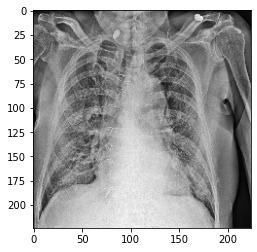

In [41]:
plt.figure()
plt.imshow(X_valIMG[2])

In [42]:
# pathOut = Path('IMG_DICOM_FILES_NO_TEXT')
# pathOut.mkdir(parents=True, exist_ok=True)

### IMAGE datagen

In [43]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [44]:
idg = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         brightness_range=[0.8,1.2],
                         zoom_range=0.1,
                         fill_mode='nearest',
                         horizontal_flip = False,
                         vertical_flip = False,
                        )

## MODELS DEFINITION AND USE

### CNN Multi layer fusion without DS

In [68]:
def ResFBlock(x,filt,kernel,stride):
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    # x = Dropout(0.6)(x)
    return x

In [69]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionConc(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(x,16,5,2)
    
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.7)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.7)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    
    block1 = Flatten()(block1)
    block2 = Flatten()(block2)
    block3 = Flatten()(block3)
    block4 = Flatten()(block4)
    block5 = Flatten()(block5)
    
    massFusion = Concatenate()([block1,block2,block3,block4,block5])

    outputs = Dense(32, activation='relu')(massFusion)
    outputs = Dense(8, activation='relu')(outputs)


    outputs = Dense(2, activation=lastActivation)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [267]:
model = DSfusionConc((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [268]:
# model.summary()

In [269]:
# plot_model(model, to_file=plotpath / Path('Multilayer_model_plot.png'), show_shapes=True, show_layer_names=True)

In [270]:
train_data_generator = idg.flow(X_trainIMG, y = Y_train[['MILD','SEVERE']],
					       seed=42, shuffle = True)
valid_data_generator = idg.flow(X_valIMG, y = Y_val[['MILD','SEVERE']],
					       seed=42, shuffle = True)
						   

In [271]:
model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),
        loss="binary_crossentropy",
        metrics=METRICS,
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
						'MultilayerFusion/callbacks/model_CONCAT_callback_CONCAT', 
						monitor='val_binary_accuracy', verbose=1, 
						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
        x = X_trainIMG,
        y = Y_train,
        epochs = 300,
        validation_data = [X_valIMG,Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size= 32
)

# history = model.fit(
#         x = train_data_generator,
#         epochs = 300,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/300
29/31 [===========================>..] - ETA: 0s - loss: 2.3866 - binary_accuracy: 0.5135 - precision: 0.5105 - recall: 0.6526 - True_Positives: 678.0000 - True_Negatives: 389.0000 - False_Positives: 650.0000 - False_Negatives: 361.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.50000, saving model to MultilayerFusion/callbacks\model_CONCAT_callback_CONCAT
INFO:tensorflow:Assets written to: MultilayerFusion/callbacks\model_CONCAT_callback_CONCAT\assets
31/31 [==============================] - 5s 127ms/step - loss: 2.3454 - binary_accuracy: 0.5145 - precision: 0.5110 - recall: 0.6727 - True_Positives: 742.0000 - True_Negatives: 393.0000 - False_Positives: 710.0000 - False_Negatives: 361.0000 - val_loss: 4.1079 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_True_Positives: 111.0000 - val_True_Negatives: 0.0000e+00 - val_False_Positives: 111.0000 - val_False_Negatives: 0.0000e+00
Epoch 2/300
30/31 [============================>.] - E

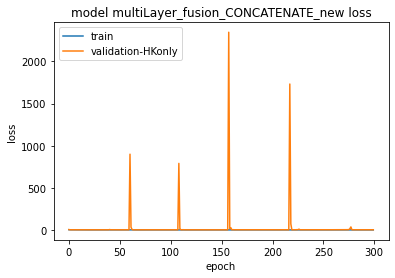

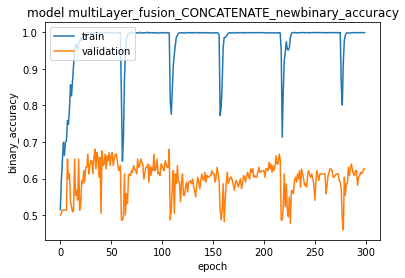

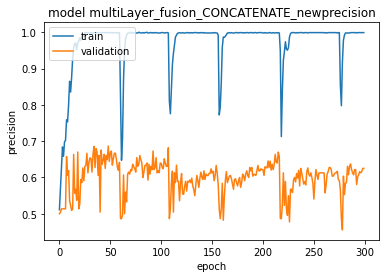

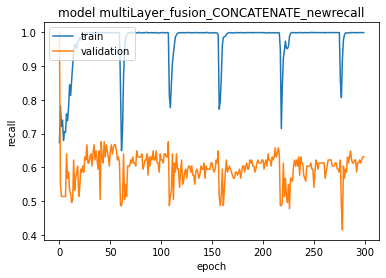

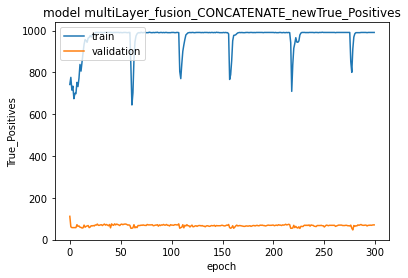

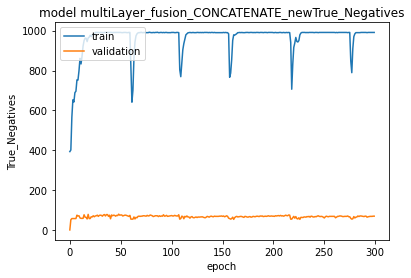

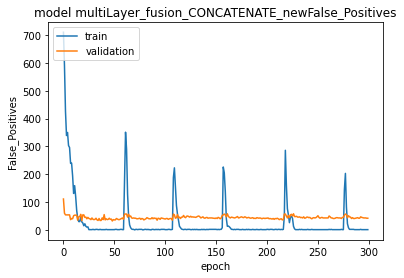

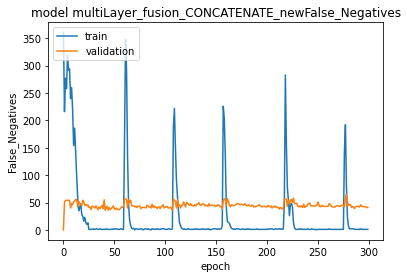

INFO:tensorflow:Assets written to: MultilayerFusion\OUTPUTS\MODELS-PB\multiLayer_fusion_CONCATENATE_new\assets


In [272]:
        
printAndSaveGraphs(graphPath,'multiLayer_fusion_CONCATENATE_new',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)
# or save to csv: 
hist_csv_file = graphPath / 'history_multiLayer_fusion_CONCATENATE_new.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / 'multiLayer_fusion_CONCATENATE_new')

In [273]:
bestPt = 'MultilayerFusion/callbacks/model_CONCAT_callback_CONCAT'
model = tf.keras.models.load_model(bestPt)

evaluation = model.evaluate(x = X_valIMG, y = Y_val)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_CONCAT_90_10.txt', 'w') as f:
    f.write('CNN FUSION BY CONCATENATION TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')

4/4 [==============================] - 1s 32ms/step - loss: 1.4483 - binary_accuracy: 0.6802 - precision: 0.6852 - recall: 0.6667 - True_Positives: 74.0000 - True_Negatives: 77.0000 - False_Positives: 34.0000 - False_Negatives: 37.0000
{'loss': 1.448261022567749, 'binary_accuracy': 0.6801801919937134, 'precision': 0.6851851940155029, 'recall': 0.6666666865348816, 'True_Positives': 74.0, 'True_Negatives': 77.0, 'False_Positives': 34.0, 'False_Negatives': 37.0}


### CNN Multi layer fusion with DS

In [208]:
prototypes = 40
# prototypes = 1
num_class = 2

In [209]:
def ResFBlock(x,filt,kernel,stride):
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Dropout(0.6)(x)
    return x

In [210]:
# def DSmassCalcLayer(lin):

#     # print(lin.shape[1])

#     ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
#     ED_ac = ds_layer.DS1_activate(prototypes)(ED)
#     mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
#     lout = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)


#     return lout
def DSmassCalcLayer(lin):

    # print(lin.shape[1])

    ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
    ED_ac = ds_layer.DS1_activate(prototypes)(ED)
    mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
    mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    # lout = ds_layer.DS3_normalize()(mass_Dempster)

    return lout




In [211]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionML(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(x,16,5,2)
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.6)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.6)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
    block1 = Flatten()(block1)
    block1 = DSmassCalcLayer(block1)
    block2 = Flatten()(block2)
    block2 = DSmassCalcLayer(block2)
    block3 = Flatten()(block3)
    block3 = DSmassCalcLayer(block3)
    block4 = Flatten()(block4)
    block4 = DSmassCalcLayer(block4)
    block5 = Flatten()(block5)
    block5 = DSmassCalcLayer(block5)
    
    # massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # massFusion = Add()([block1,block2,block3,block4,block5])
    # massFusion = layers.Average()([block1,block2,block3,block4,block5])
    massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # print(massFusion)

    #MASS ON CONCATENATION
    # print(massFusion.shape)
    # pt = math.floor(massFusion.shape[1]/50)

    # ED = ds_layer.DS1(pt,massFusion.shape[1])(massFusion)
    # ED_ac = ds_layer.DS1_activate(pt)(ED)
    # mass_prototypes = ds_layer.DS2(pt, num_class)(ED_ac)
    # mass_omega = ds_layer.DS2_omega(pt, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(pt, num_class)(mass_omega)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)


    # DA DS2 IN DS3
    newNprot = (num_class+1)*5
    mass_prototypes = ds_layer.DS2(newNprot, num_class)(massFusion)
    mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
    

    # # DA DS1 IN DS3
    # # newNprot = (num_class+1)*5
    # newNprot = 40
    # ED = ds_layer.DS1(newNprot,massFusion.shape[1])(massFusion)
    # ED_ac = ds_layer.DS1_activate(newNprot)(ED)
    # mass_prototypes = ds_layer.DS2(newNprot, num_class)(ED_ac)
    # mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)



    # massFusion = AveragePooling1D(data_format="channels_first")(massFusion)
    # print(massFusion)
    # massFusion = AveragePooling1D(data_format="channels_first")(massFusion)
    # print(massFusion)

    # mass_Dempster = ds_layer.DS3_Dempster(5*prototypes, num_class)(massFusion)
    # # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(massFusion)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

    # #Utility layer for testing
    outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster_normalize)
    # outputs = utility_layer_train.DM(0.9,num_class)(mass_Dempster_normalize)
    # outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [212]:
model = DSfusionML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [213]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_13 (Rescaling)       (None, 224, 224, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv2d_208 (Conv2D)            (None, 112, 112, 16  1216        ['rescaling_13[0][0]']           
                                )                                                                 
                                                                                           

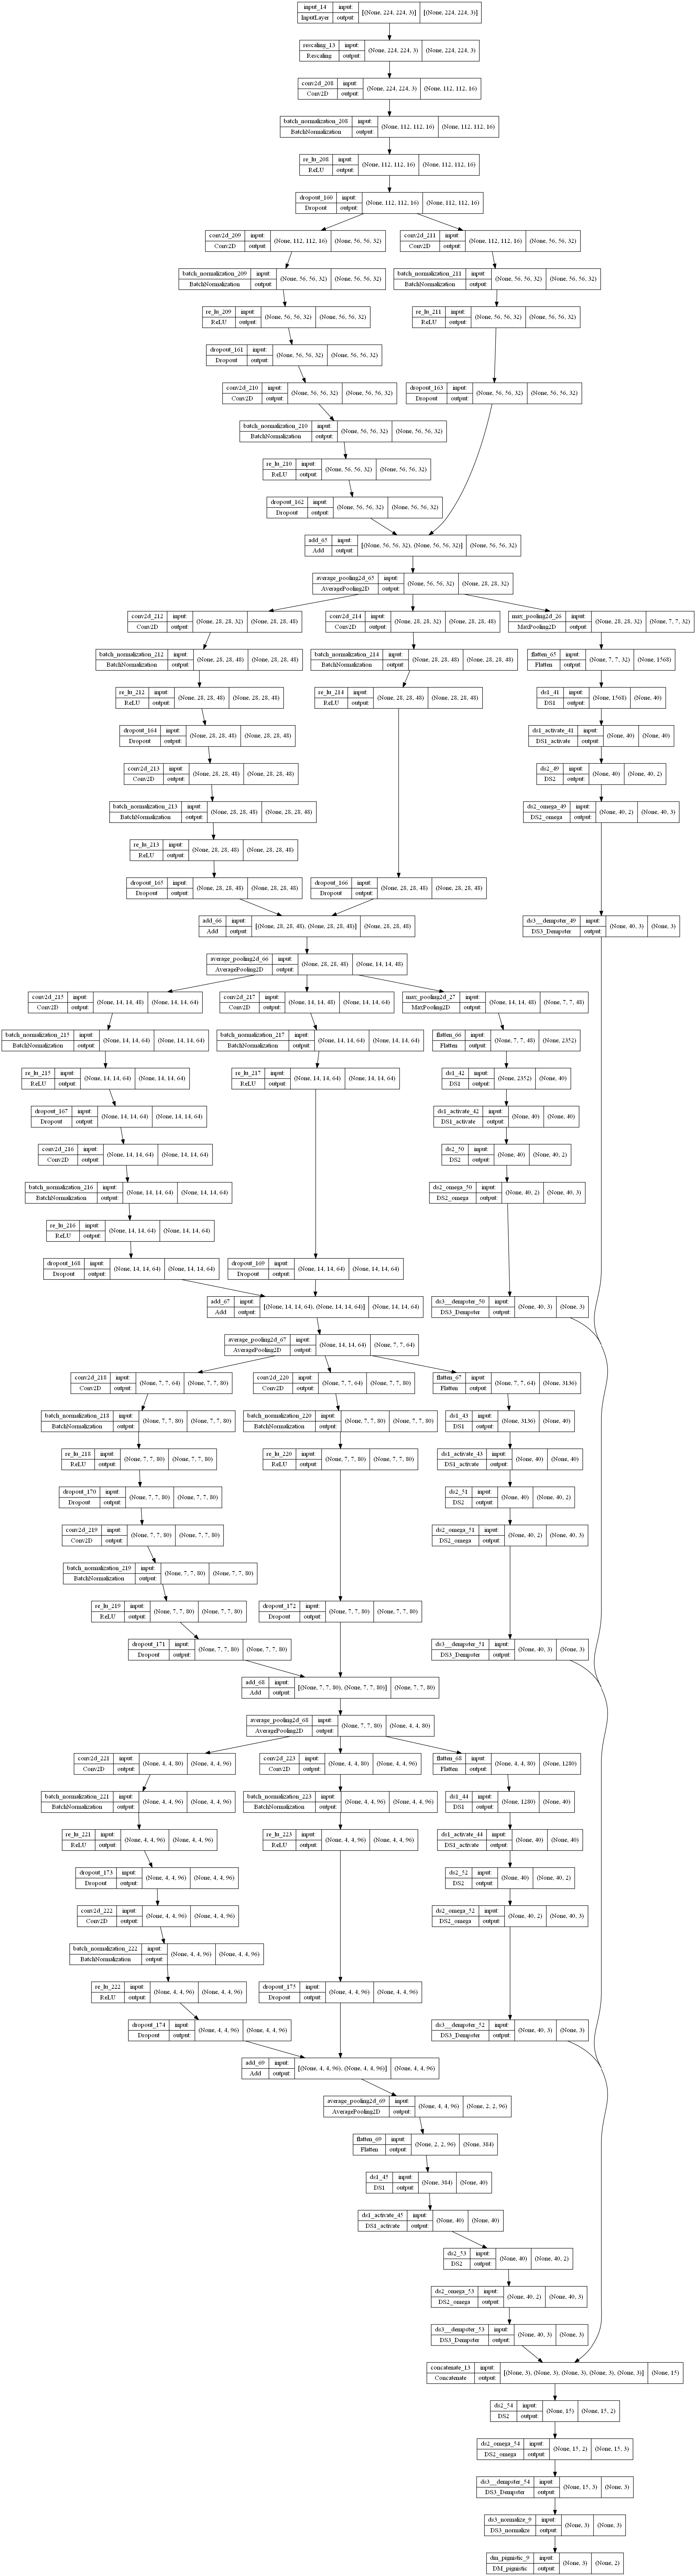

In [214]:
plot_model(model, to_file=plotpath / Path('DS_Multilayer_model_plot.png'), show_shapes=True, show_layer_names=True)

In [215]:
train_data_generator = idg.flow(X_trainIMG, y = Y_train[['MILD','SEVERE']],
					       seed=42, shuffle = True, batch_size=8)
valid_data_generator = idg.flow(X_valIMG, y = Y_val[['MILD','SEVERE']],
					       seed=42, shuffle = True, batch_size=8)
						   

In [216]:
# def decay_lrate(initial_lrate, decay, iteration):
# 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False
)

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
        # optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(lr_schedule),
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        loss="binary_crossentropy",
        # loss="hinge",
        metrics=METRICS,
)

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						'MultilayerFusion/callbacks/model_DS_callback_DS_not_gen_2', 
						monitor='val_binary_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/model_DS_callback_DS', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
        x = X_trainIMG,
        y = Y_train,
        epochs = 300,
        validation_data = [X_valIMG,Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32
)
# history = model.fit(
#         x = train_data_generator,
#         epochs = 500,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/300
31/31 [==============================] - ETA: 0s - loss: 1.1318 - binary_accuracy: 0.5231 - precision: 0.5231 - recall: 0.5231 - True_Positives: 577.0000 - True_Negatives: 577.0000 - False_Positives: 526.0000 - False_Negatives: 526.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.51351, saving model to MultilayerFusion/callbacks\model_DS_callback_DS_not_gen_2
INFO:tensorflow:Assets written to: MultilayerFusion/callbacks\model_DS_callback_DS_not_gen_2\assets
31/31 [==============================] - 49s 890ms/step - loss: 1.1318 - binary_accuracy: 0.5231 - precision: 0.5231 - recall: 0.5231 - True_Positives: 577.0000 - True_Negatives: 577.0000 - False_Positives: 526.0000 - False_Negatives: 526.0000 - val_loss: 2.6423 - val_binary_accuracy: 0.5135 - val_precision: 0.5135 - val_recall: 0.5135 - val_True_Positives: 57.0000 - val_True_Negatives: 57.0000 - val_False_Positives: 54.0000 - val_False_Negatives: 54.0000
Epoch 2/300
31/31 [==============================] - ETA:

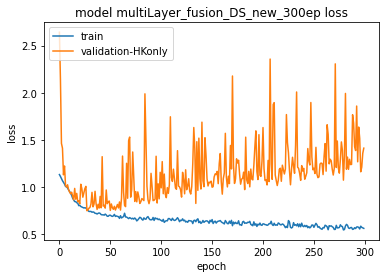

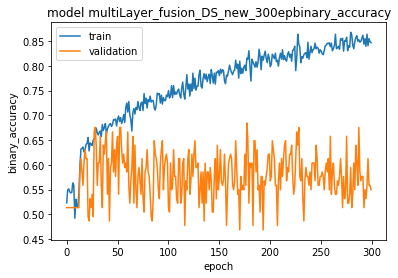

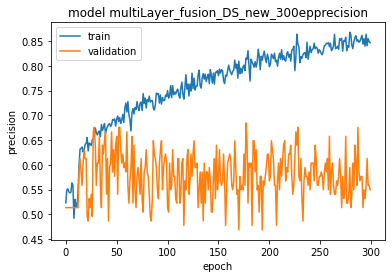

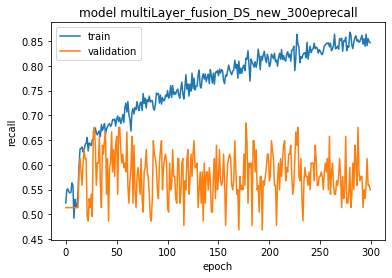

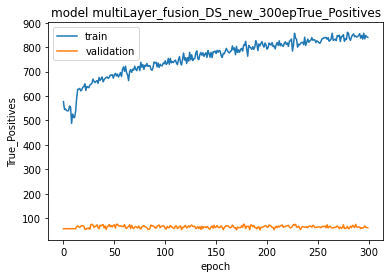

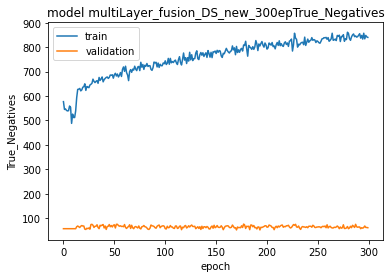

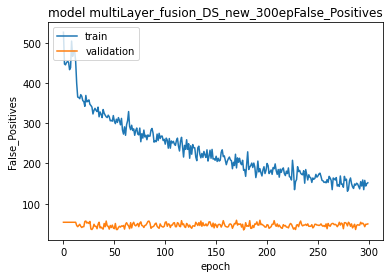

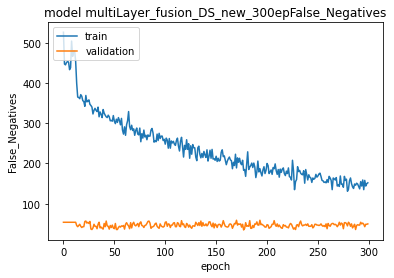

INFO:tensorflow:Assets written to: MultilayerFusion\OUTPUTS\MODELS-PB\multiLayer_fusion_DS_new_300ep\assets


In [217]:
printAndSaveGraphs(graphPath,'multiLayer_fusion_DS_new_300ep',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)

# save to csv: 
hist_csv_file = graphPath / Path('history_multiLayer_fusion_DS_new_300ep.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / Path('multiLayer_fusion_DS_new_300ep'))

In [218]:
bestPt = 'MultilayerFusion/callbacks/model_DS_callback_DS_not_gen_2'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_DS_OLD_90_10.txt', 'w') as f:
    f.write('CNN FUSION BY DS ON BLOCK FLATTEN TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')

4/4 [==============================] - 3s 64ms/step - loss: 1.1355 - binary_accuracy: 0.6847 - precision: 0.6847 - recall: 0.6847 - True_Positives: 76.0000 - True_Negatives: 76.0000 - False_Positives: 35.0000 - False_Negatives: 35.0000
{'loss': 1.1355112791061401, 'binary_accuracy': 0.684684693813324, 'precision': 0.684684693813324, 'recall': 0.684684693813324, 'True_Positives': 76.0, 'True_Negatives': 76.0, 'False_Positives': 35.0, 'False_Negatives': 35.0}


### CNN Multi layer fusion with DS test on flatten

In [85]:
prototypes = 32
# prototypes = 1
num_class = 2

In [86]:
def ResFBlock(x,filt,kernel,stride):
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Dropout(0.6)(x)
    return x

In [87]:
# def DSmassCalcLayer(lin):

#     # print(lin.shape[1])

#     ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
#     ED_ac = ds_layer.DS1_activate(prototypes)(ED)
#     mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
#     lout = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)


#     return lout
def DSmassCalcLayer(lin):

    # print(lin.shape[1])

    ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
    ED_ac = ds_layer.DS1_activate(prototypes)(ED)
    mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
    mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    # lout = ds_layer.DS3_normalize()(mass_Dempster)

    return lout




In [88]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionFeaturesML(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(x,16,5,2)
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.6)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.6)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
    block1 = Flatten()(block1)
    block1 = Dense(32, activation='relu')(block1)
    block1 = DSmassCalcLayer(block1)
    block2 = Flatten()(block2)
    block2 = Dense(32, activation='relu')(block2)
    block2 = DSmassCalcLayer(block2)
    block3 = Flatten()(block3)
    block3 = Dense(32, activation='relu')(block3)
    block3 = DSmassCalcLayer(block3)
    block4 = Flatten()(block4)
    block4 = Dense(32, activation='relu')(block4)
    block4 = DSmassCalcLayer(block4)
    block5 = Flatten()(block5)
    block5 = Dense(32, activation='relu')(block5)
    block5 = DSmassCalcLayer(block5)
    
    # massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # massFusion = Add()([block1,block2,block3,block4,block5])
    # massFusion = layers.Average()([block1,block2,block3,block4,block5])
    massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # print(massFusion)

    #MASS ON CONCATENATION
    # print(massFusion.shape)
    # pt = math.floor(massFusion.shape[1]/50)

    # ED = ds_layer.DS1(pt,massFusion.shape[1])(massFusion)
    # ED_ac = ds_layer.DS1_activate(pt)(ED)
    # mass_prototypes = ds_layer.DS2(pt, num_class)(ED_ac)
    # mass_omega = ds_layer.DS2_omega(pt, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(pt, num_class)(mass_omega)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)


    # DA DS2 IN DS3
    newNprot = (num_class+1)*5
    mass_prototypes = ds_layer.DS2(newNprot, num_class)(massFusion)
    mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
    

    # # DA DS1 IN DS3
    # # newNprot = (num_class+1)*5
    # newNprot = 40
    # ED = ds_layer.DS1(newNprot,massFusion.shape[1])(massFusion)
    # ED_ac = ds_layer.DS1_activate(newNprot)(ED)
    # mass_prototypes = ds_layer.DS2(newNprot, num_class)(ED_ac)
    # mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)



    # massFusion = AveragePooling1D(data_format="channels_first")(massFusion)
    # print(massFusion)
    # massFusion = AveragePooling1D(data_format="channels_first")(massFusion)
    # print(massFusion)

    # mass_Dempster = ds_layer.DS3_Dempster(5*prototypes, num_class)(massFusion)
    # # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(massFusion)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

    # #Utility layer for testing
    outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster_normalize)
    # outputs = utility_layer_train.DM(0.9,num_class)(mass_Dempster_normalize)
    # outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [67]:
model = DSfusionFeaturesML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [68]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  1216        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

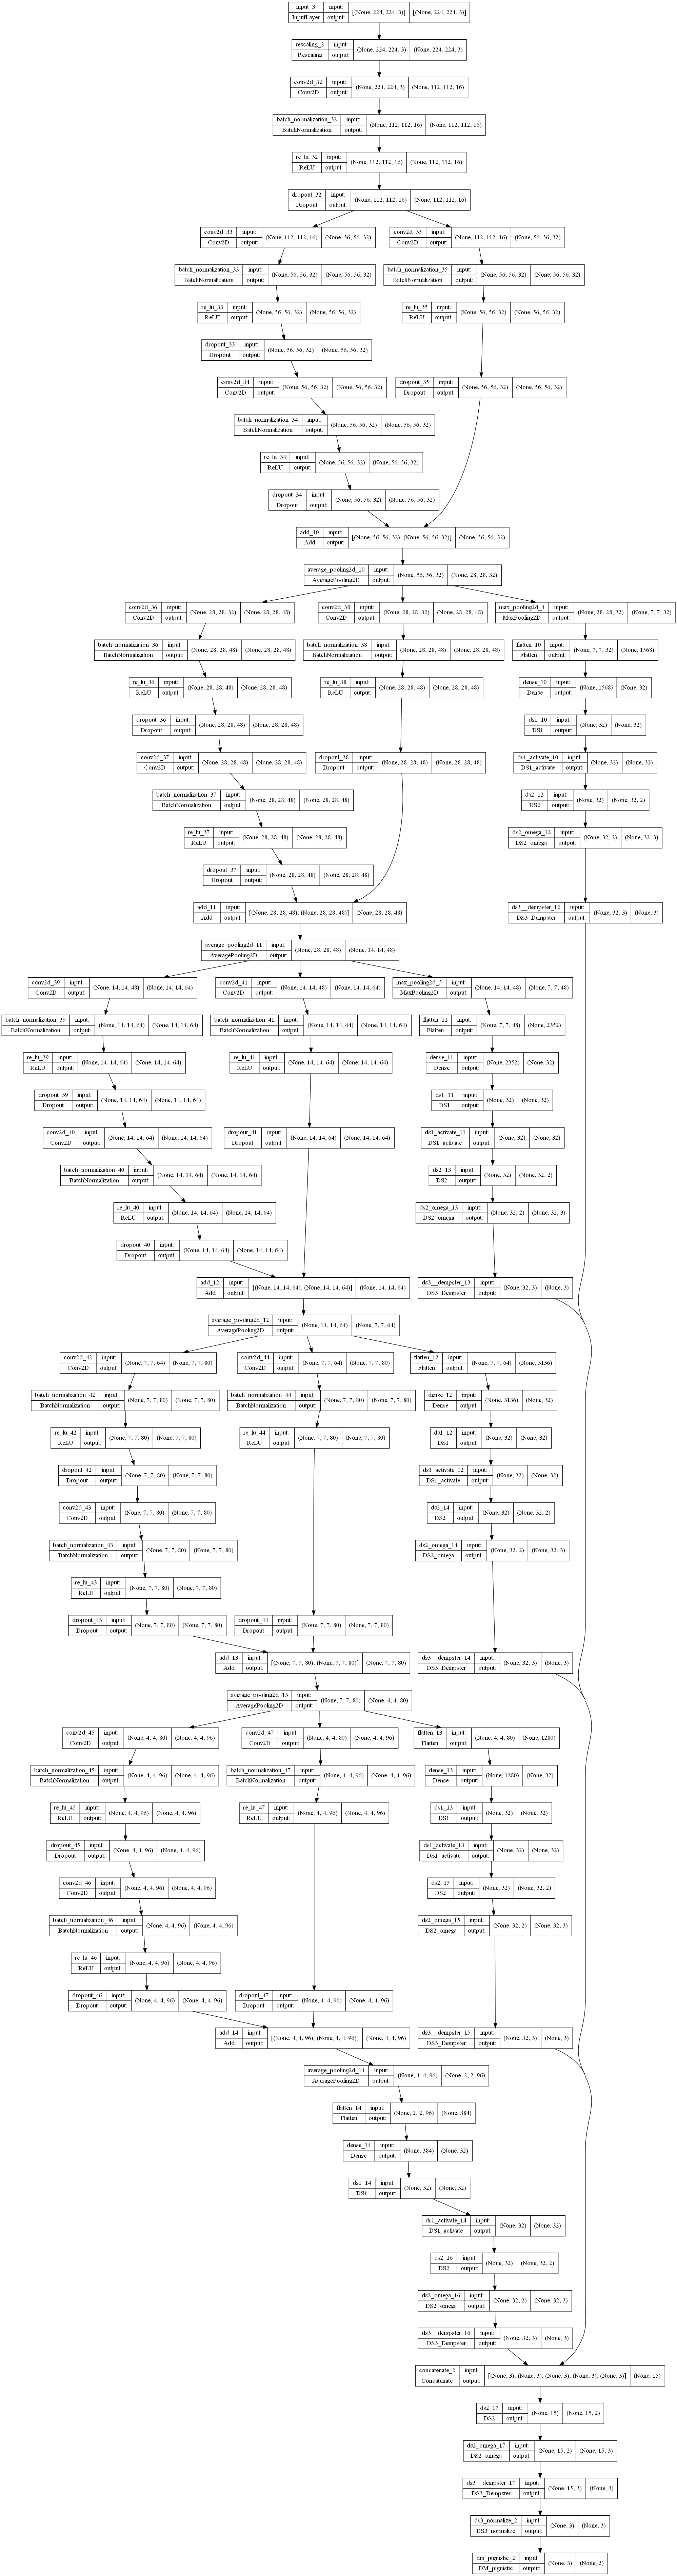

In [108]:
plot_model(model, to_file=plotpath / Path('DS_Multilayer_model_plot.png'), show_shapes=True, show_layer_names=True)

In [109]:
# def decay_lrate(initial_lrate, decay, iteration):
# 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False
)

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
        # optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(lr_schedule),
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        loss="categorical_crossentropy",
        # loss="hinge",
        metrics=METRICS,
)

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						'MultilayerFusion/callbacks/model_DS_callback_DS_ON_DENSE', 
						monitor='val_binary_accuracy', verbose=1, 
						# monitor='categorical_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/model_DS_callback_DS', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
        x = X_trainIMG,
        y = Y_train,
        epochs = 300,
        validation_data = [X_valIMG,Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32
)
# history = model.fit(
#         x = train_data_generator,
#         epochs = 500,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/300
31/31 [==============================] - ETA: 0s - loss: 1.0722 - binary_accuracy: 0.5735 - precision: 0.5735 - recall: 0.5735 - True_Positives: 624.0000 - True_Negatives: 624.0000 - False_Positives: 464.0000 - False_Negatives: 464.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.43243, saving model to MultilayerFusion/callbacks\model_DS_callback_DS_ON_DENSE
INFO:tensorflow:Assets written to: MultilayerFusion/callbacks\model_DS_callback_DS_ON_DENSE\assets
31/31 [==============================] - 39s 703ms/step - loss: 1.0722 - binary_accuracy: 0.5735 - precision: 0.5735 - recall: 0.5735 - True_Positives: 624.0000 - True_Negatives: 624.0000 - False_Positives: 464.0000 - False_Negatives: 464.0000 - val_loss: 1.2768 - val_binary_accuracy: 0.4324 - val_precision: 0.4324 - val_recall: 0.4324 - val_True_Positives: 48.0000 - val_True_Negatives: 48.0000 - val_False_Positives: 63.0000 - val_False_Negatives: 63.0000
Epoch 2/300
31/31 [==============================] - ETA: 0

InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Michele\AppData\Local\Temp/ipykernel_6324/4082395522.py", line 31, in <module>
      history = model.fit(
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Michele\AppData\Local\Temp/ipykernel_6324/4082395522.py", line 31, in <module>
      history = model.fit(
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_2/dm_pignistic_2/strided_slice_2:0) = ] [[0.934286475 0.0657135472][0.899317861...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_3/Assert/AssertGuard/pivot_f/_63/_111]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_2/dm_pignistic_2/strided_slice_2:0) = ] [[0.934286475 0.0657135472][0.899317861...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1036834]

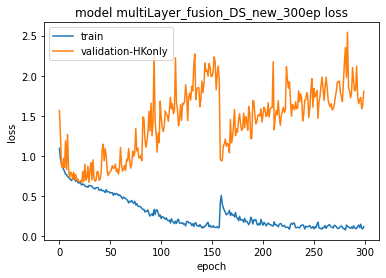

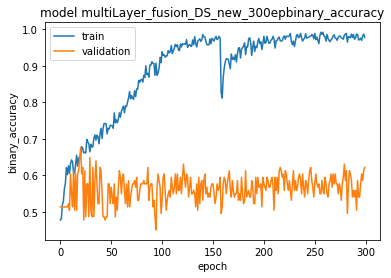

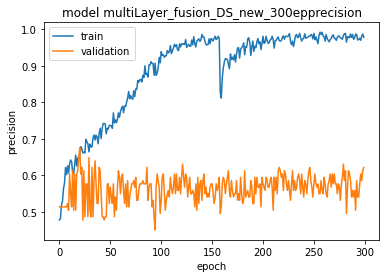

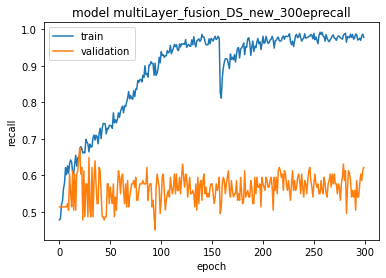

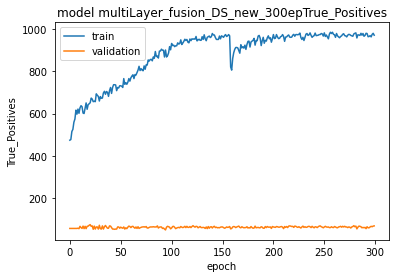

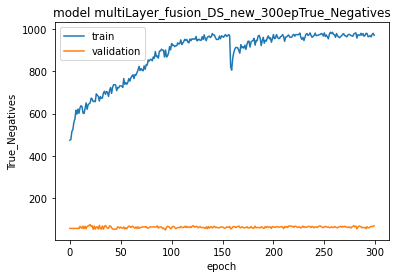

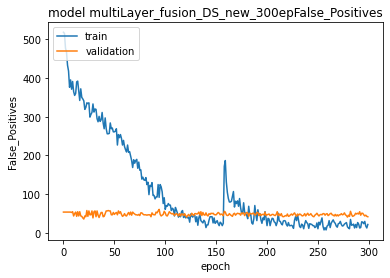

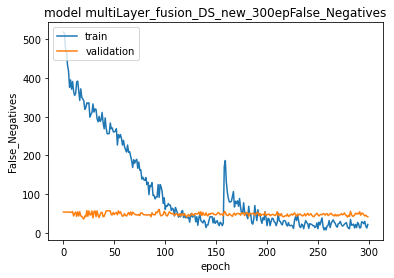

INFO:tensorflow:Assets written to: MultilayerFusion\OUTPUTS\MODELS-PB\multiLayer_fusion_DS_new_300ep\assets


In [ ]:
printAndSaveGraphs(graphPath,'multiLayer_fusion_DS_new_300ep',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)

# save to csv: 
hist_csv_file = graphPath / Path('history_multiLayer_fusion_DS_new_300ep.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / Path('multiLayer_fusion_DS_new_300ep'))

In [ ]:
bestPt = 'MultilayerFusion/callbacks/model_DS_callback_DS_ON_DENSE'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_DS_OLD_ON_DENSE_90_10.txt', 'w') as f:
    f.write('CNN FUSION BY DS ON DENSE 32 ON BLOCK FLATTEN (32 PROTOTYPES) TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')

4/4 [==============================] - 2s 49ms/step - loss: 0.7016 - binary_accuracy: 0.6577 - precision: 0.6577 - recall: 0.6577 - True_Positives: 73.0000 - True_Negatives: 73.0000 - False_Positives: 38.0000 - False_Negatives: 38.0000
{'loss': 0.7016373872756958, 'binary_accuracy': 0.6576576828956604, 'precision': 0.6576576828956604, 'recall': 0.6576576828956604, 'True_Positives': 73.0, 'True_Negatives': 73.0, 'False_Positives': 38.0, 'False_Negatives': 38.0}


### CNN Multy layer fusion with DS output

In [240]:
prototypes = 40
# prototypes = 1
num_class = 2

In [241]:
def ResFBlock(x,filt,kernel,stride):
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Dropout(0.6)(x)
    return x

In [242]:
# def DSmassCalcLayer(lin):

#     # print(lin.shape[1])

#     ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
#     ED_ac = ds_layer.DS1_activate(prototypes)(ED)
#     mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
#     lout = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)


#     return lout
def DSmassCalcLayer(lin):

    # print(lin.shape[1])

    ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
    ED_ac = ds_layer.DS1_activate(prototypes)(ED)
    mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
    mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    # lout = ds_layer.DS3_normalize()(mass_Dempster)

    return lout




In [243]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionOutputsML(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(x,16,5,2)
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.6)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.6)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
    block1 = Flatten()(block1)
    block1 = Dense(32, activation='relu')(block1)
    block1 = Dense(8, activation='relu')(block1)
    block1 = Dense(2, activation=lastActivation)(block1)
    # block1 = DSmassCalcLayer(block1)

    block2 = Flatten()(block2)
    block2 = Dense(32, activation='relu')(block2)
    block2 = Dense(8, activation='relu')(block2)
    block2 = Dense(2, activation=lastActivation)(block2)
    # block2 = DSmassCalcLayer(block2)

    block3 = Flatten()(block3)
    block3 = Dense(32, activation='relu')(block3)
    block3 = Dense(8, activation='relu')(block3)
    block3 = Dense(2, activation=lastActivation)(block3)
    # block3 = DSmassCalcLayer(block3)

    block4 = Flatten()(block4)
    block4 = Dense(32, activation='relu')(block4)
    block4 = Dense(8, activation='relu')(block4)
    block4 = Dense(2, activation=lastActivation)(block4)
    # block4 = DSmassCalcLayer(block4)

    block5 = Flatten()(block5)
    block5 = Dense(32, activation='relu')(block5)
    block5 = Dense(8, activation='relu')(block5)
    block5 = Dense(2, activation=lastActivation)(block5)
    # block5 = DSmassCalcLayer(block5)
    



    massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # print(massFusion)

    # DA DS2 IN DS3
    
    
    newNprot = (num_class)*5
    
    ED = ds_layer.DS1(prototypes,massFusion.shape[1])(massFusion)
    ED_ac = ds_layer.DS1_activate(prototypes)(ED)   
    mass_prototypes = ds_layer.DS2(newNprot, num_class)(ED_ac)
    mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

    # # DA DS2 IN DS3
    # newNprot = (num_class+1)*5
    # mass_prototypes = ds_layer.DS2(newNprot, num_class)(massFusion)
    # mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    # mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

    # #Utility layer for testing
    outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster_normalize)

    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [244]:
model = DSfusionOutputsML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [245]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_16 (Rescaling)       (None, 224, 224, 3)  0           ['input_17[0][0]']               
                                                                                                  
 conv2d_256 (Conv2D)            (None, 112, 112, 16  1216        ['rescaling_16[0][0]']           
                                )                                                                 
                                                                                           

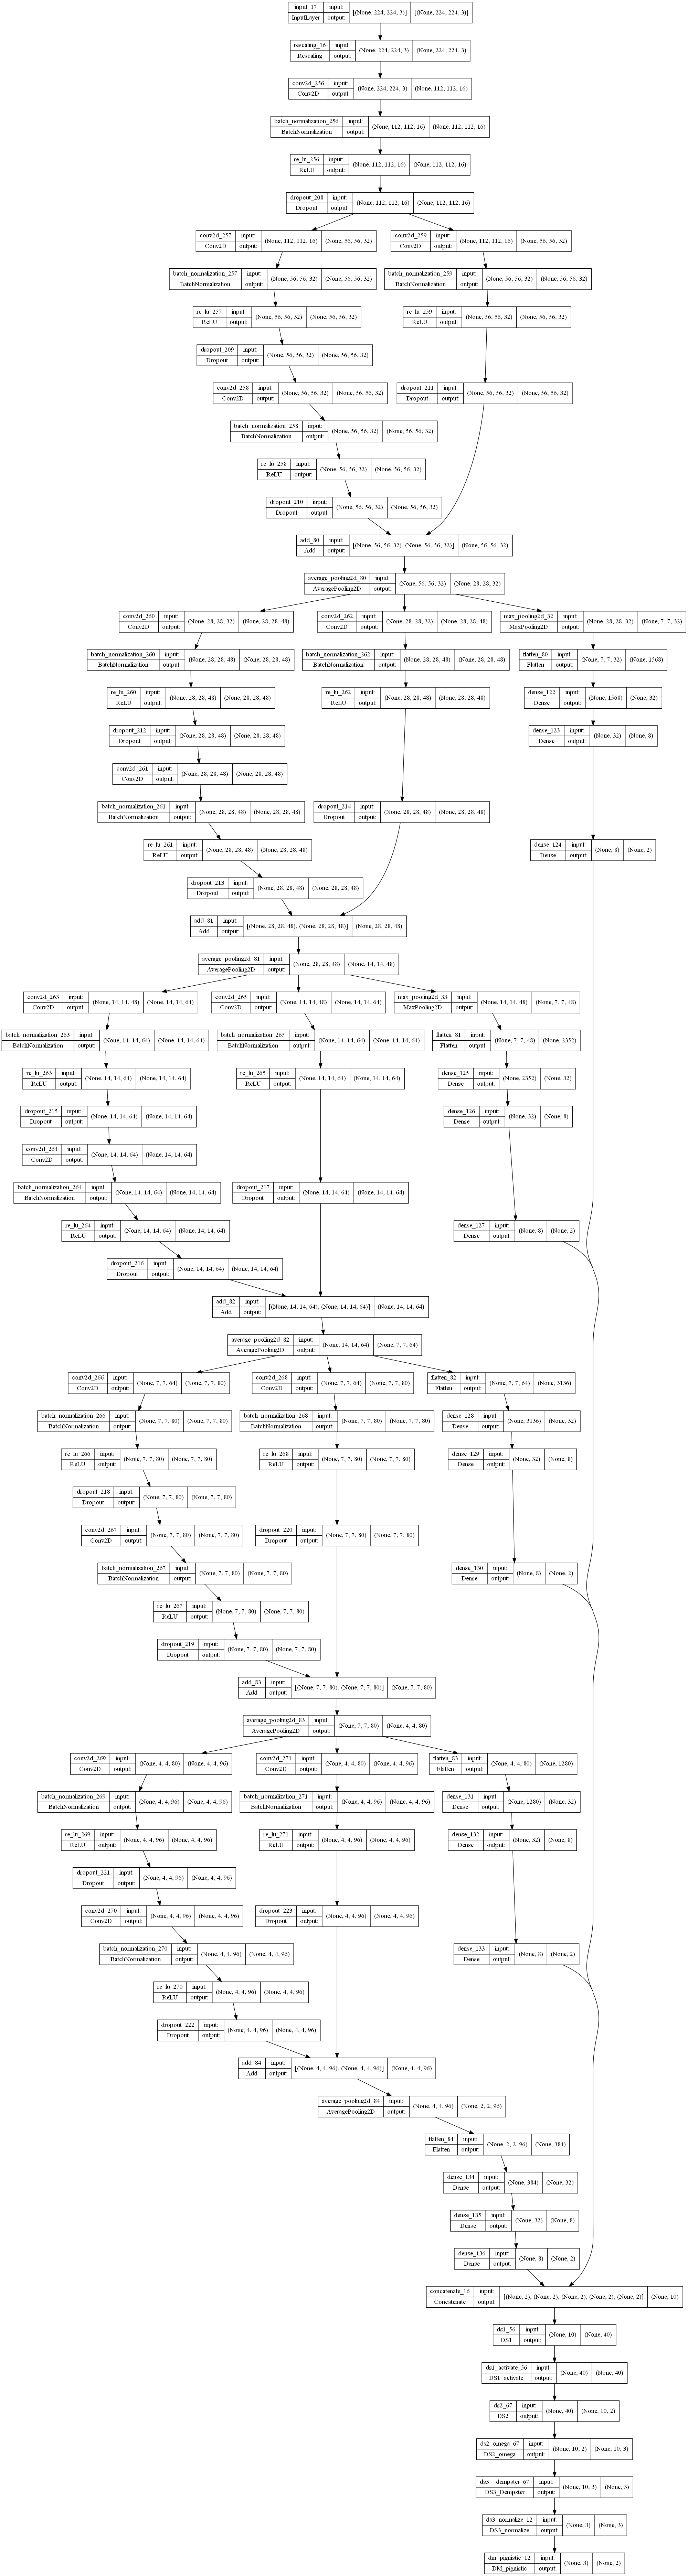

In [246]:
plot_model(model, to_file=plotpath / Path('DS_Multilayer_model_plot.png'), show_shapes=True, show_layer_names=True)

In [247]:
train_data_generator = idg.flow(X_trainIMG, y = Y_train[['MILD','SEVERE']],
					       seed=42, shuffle = True, batch_size=8)
valid_data_generator = idg.flow(X_valIMG, y = Y_val[['MILD','SEVERE']],
					       seed=42, shuffle = True, batch_size=8)
						   

In [248]:
# def decay_lrate(initial_lrate, decay, iteration):
# 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False
)

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
        optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        loss="binary_crossentropy",
        # loss="hinge",
        metrics=METRICS,
)

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						'MultilayerFusion/callbacks/model_DS_DECISION_AND_FUSION', 
						monitor='val_binary_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/model_DS_callback_DS', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
        x = X_trainIMG,
        y = Y_train,
        epochs = 300,
        validation_data = [X_valIMG,Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32
)
# history = model.fit(
#         x = train_data_generator,
#         epochs = 500,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/300
31/31 [==============================] - ETA: 0s - loss: 1.0898 - binary_accuracy: 0.5050 - precision: 0.5050 - recall: 0.5050 - True_Positives: 557.0000 - True_Negatives: 557.0000 - False_Positives: 546.0000 - False_Negatives: 546.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.48649, saving model to MultilayerFusion/callbacks\model_DS_DECISION_AND_FUSION
INFO:tensorflow:Assets written to: MultilayerFusion/callbacks\model_DS_DECISION_AND_FUSION\assets
31/31 [==============================] - 10s 235ms/step - loss: 1.0898 - binary_accuracy: 0.5050 - precision: 0.5050 - recall: 0.5050 - True_Positives: 557.0000 - True_Negatives: 557.0000 - False_Positives: 546.0000 - False_Negatives: 546.0000 - val_loss: 0.8827 - val_binary_accuracy: 0.4865 - val_precision: 0.4865 - val_recall: 0.4865 - val_True_Positives: 54.0000 - val_True_Negatives: 54.0000 - val_False_Positives: 57.0000 - val_False_Negatives: 57.0000
Epoch 2/300
31/31 [==============================] - ETA: 0s 

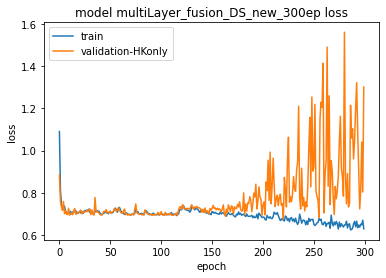

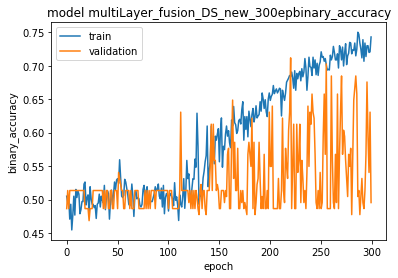

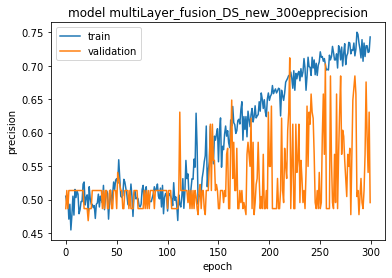

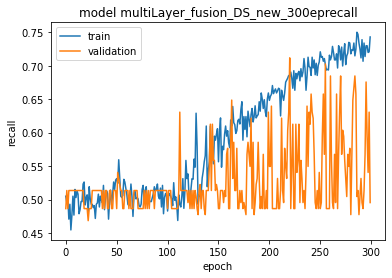

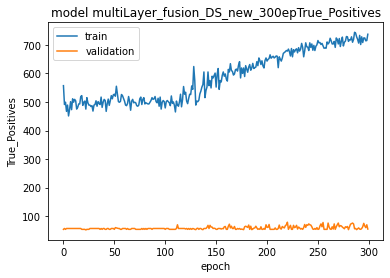

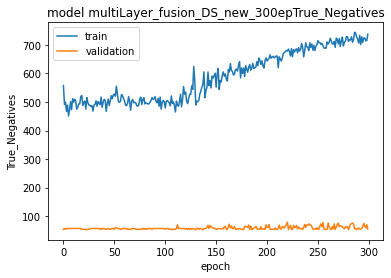

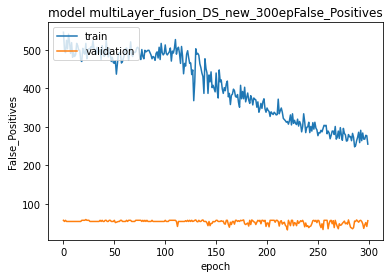

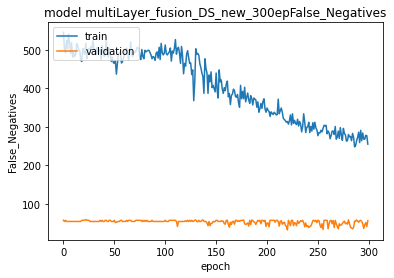

INFO:tensorflow:Assets written to: MultilayerFusion\OUTPUTS\MODELS-PB\multiLayer_fusion_DS_new_300ep\assets


In [249]:
printAndSaveGraphs(graphPath,'multiLayer_fusion_DS_new_300ep',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)

# save to csv: 
hist_csv_file = graphPath / Path('history_multiLayer_fusion_DS_new_300ep.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / Path('multiLayer_fusion_DS_new_300ep'))

In [250]:
bestPt = 'MultilayerFusion/callbacks/model_DS_DECISION_AND_FUSION'
model = tf.keras.models.load_model(bestPt)

evaluation = model.evaluate(x = X_valIMG, y = Y_val)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_DS_ON_CONCAT_OUTPUT_EACH_LR_90_10.txt', 'w') as f:
    f.write('CNN FUSION BY DS ON CONCATENATION OF OUTPUT OF EACH LAYER TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')

4/4 [==============================] - 1s 8ms/step - loss: 0.6763 - binary_accuracy: 0.7117 - precision: 0.7117 - recall: 0.7117 - True_Positives: 79.0000 - True_Negatives: 79.0000 - False_Positives: 32.0000 - False_Negatives: 32.0000
{'loss': 0.6763476729393005, 'binary_accuracy': 0.7117117047309875, 'precision': 0.7117117047309875, 'recall': 0.7117117047309875, 'True_Positives': 79.0, 'True_Negatives': 79.0, 'False_Positives': 32.0, 'False_Negatives': 32.0}


### CNN Multy layer fusion with DS MASSES OUTPUT

In [76]:
prototypes = 2
# prototypes = 1
num_class = 2

In [77]:
def ResFBlock(x,filt,kernel,stride):
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Dropout(0.6)(x)
    return x

In [78]:
# def DSmassCalcLayer(lin):

#     # print(lin.shape[1])

#     ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
#     ED_ac = ds_layer.DS1_activate(prototypes)(ED)
#     mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
#     lout = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)


#     return lout
def DSmassCalcLayer(lin):

    # print(lin.shape[1])

    ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
    ED_ac = ds_layer.DS1_activate(prototypes)(ED)
    mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
    mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    # lout = ds_layer.DS3_normalize()(mass_Dempster)

    return lout




In [79]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSDecisionfusionOutML(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(x,16,5,2)
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.6)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.6)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    
    block1 = Flatten()(block1)
    block1 = Dense(32, activation='relu')(block1)
    block1 = Dense(8, activation='relu')(block1)
    block1 = Dense(2, activation=lastActivation)(block1)
    block1 = DSmassCalcLayer(block1)

    block2 = Flatten()(block2)
    block2 = Dense(32, activation='relu')(block2)
    block2 = Dense(8, activation='relu')(block2)
    block2 = Dense(2, activation=lastActivation)(block2)
    block2 = DSmassCalcLayer(block2)

    block3 = Flatten()(block3)
    block3 = Dense(32, activation='relu')(block3)
    block3 = Dense(8, activation='relu')(block3)
    block3 = Dense(2, activation=lastActivation)(block3)
    block3 = DSmassCalcLayer(block3)

    block4 = Flatten()(block4)
    block4 = Dense(32, activation='relu')(block4)
    block4 = Dense(8, activation='relu')(block4)
    block4 = Dense(2, activation=lastActivation)(block4)
    block4 = DSmassCalcLayer(block4)

    block5 = Flatten()(block5)
    block5 = Dense(32, activation='relu')(block5)
    block5 = Dense(8, activation='relu')(block5)
    block5 = Dense(2, activation=lastActivation)(block5)
    block5 = DSmassCalcLayer(block5)
    



    massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # print(massFusion)

    # DA DS2 IN DS3

    # DA DS2 IN DS3
    newNprot = (num_class+1)*5
    mass_prototypes = ds_layer.DS2(newNprot, num_class)(massFusion)
    mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

    # #Utility layer for testing
    outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster_normalize)

    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [118]:
model = DSDecisionfusionOutML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [119]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 112, 112, 16  1216        ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

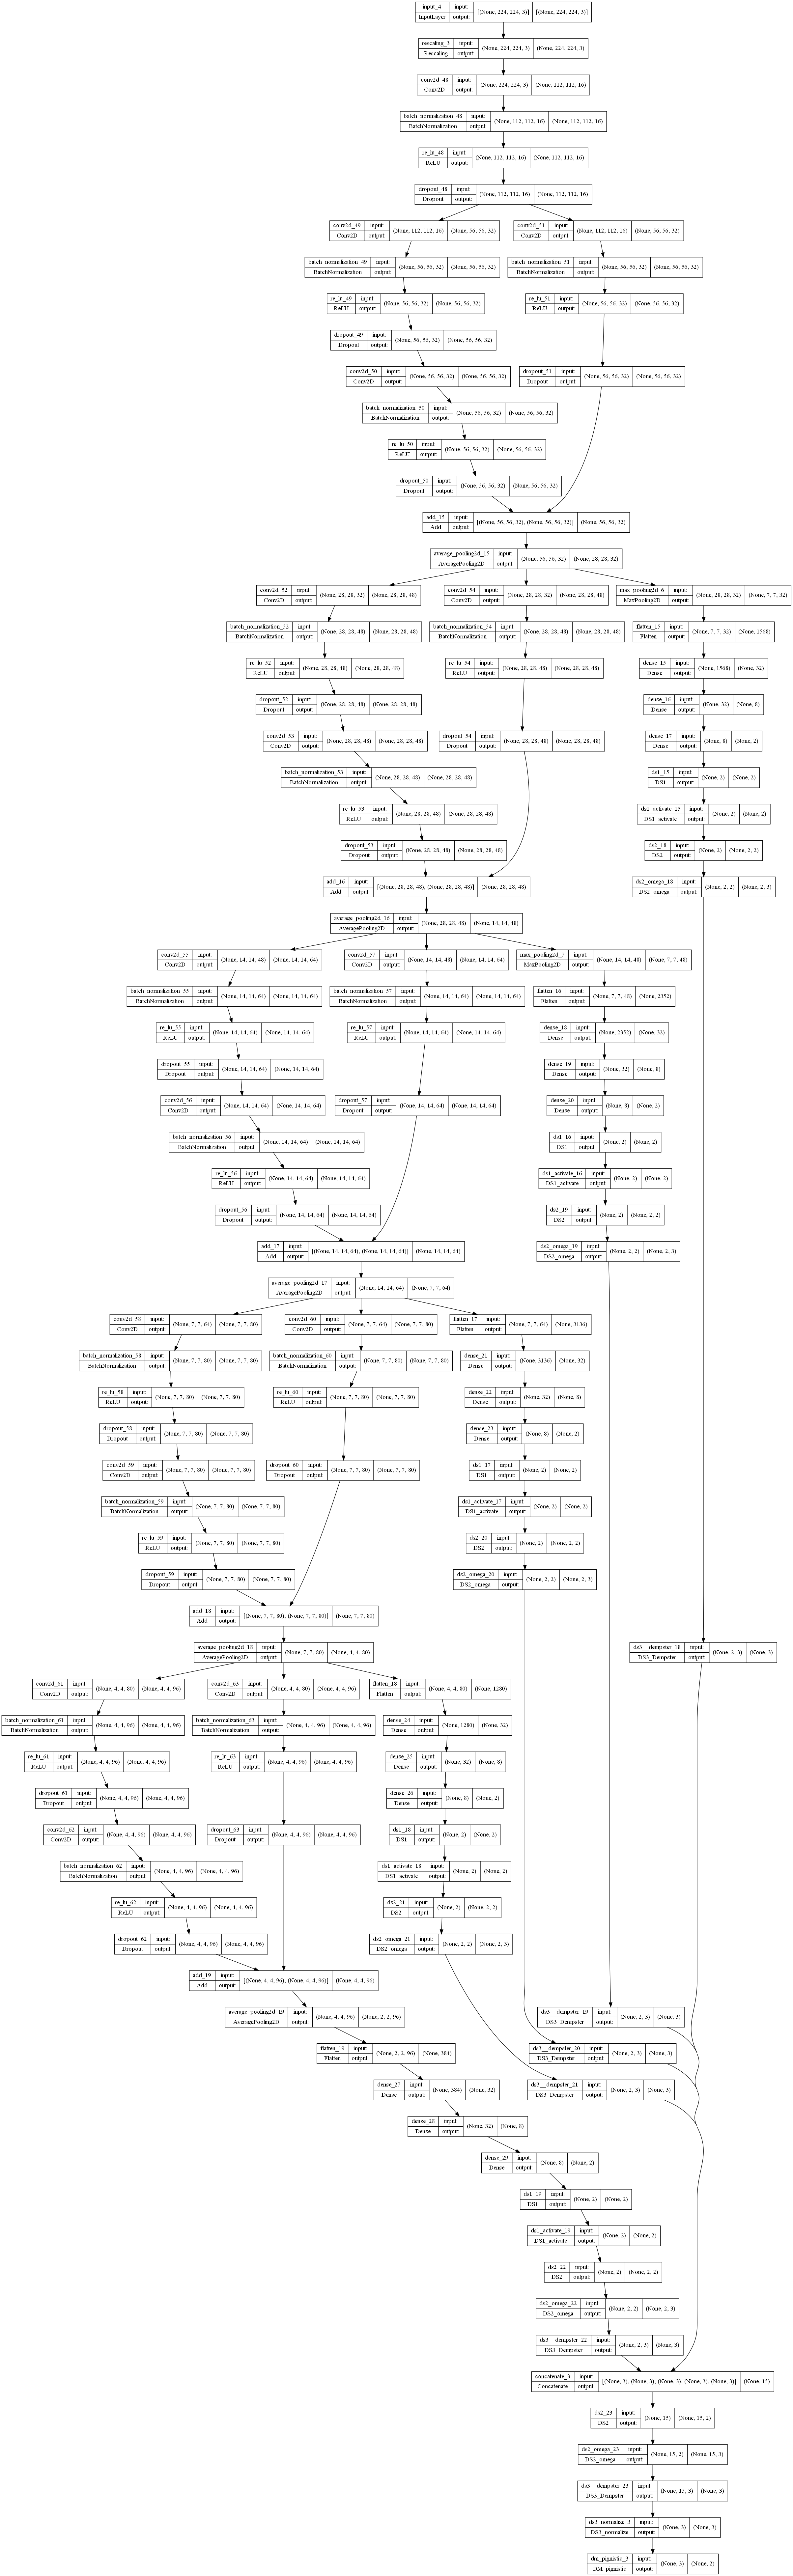

In [120]:
plot_model(model, to_file=plotpath / Path('DS_Multilayer_model_plot.png'), show_shapes=True, show_layer_names=True)

In [121]:
train_data_generator = idg.flow(X_trainIMG, y = Y_train[['MILD','SEVERE']],
					       seed=42, shuffle = True, batch_size=8)
valid_data_generator = idg.flow(X_valIMG, y = Y_val[['MILD','SEVERE']],
					       seed=42, shuffle = True, batch_size=8)
						   

In [122]:
# def decay_lrate(initial_lrate, decay, iteration):
# 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False
)

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
        # optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(lr_schedule),
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        loss="binary_crossentropy",
        # loss="hinge",
        metrics=METRICS,
)

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						'MultilayerFusion/callbacks/model_DS_DECISION_FUSION', 
						monitor='val_binary_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/model_DS_callback_DS', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
        x = X_trainIMG,
        y = Y_train,
        epochs = 300,
        validation_data = [X_valIMG,Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=32
)
# history = model.fit(
#         x = train_data_generator,
#         epochs = 500,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/300
29/31 [===========================>..] - ETA: 0s - loss: 1.4592 - binary_accuracy: 0.6466 - precision: 0.6466 - recall: 0.6466 - True_Positives: 869.0000 - True_Negatives: 869.0000 - False_Positives: 475.0000 - False_Negatives: 475.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.51351, saving model to MultilayerFusion/callbacks\model_DS_DECISION_FUSION
INFO:tensorflow:Assets written to: MultilayerFusion/callbacks\model_DS_DECISION_FUSION\assets
31/31 [==============================] - 16s 244ms/step - loss: 1.4447 - binary_accuracy: 0.6399 - precision: 0.6399 - recall: 0.6399 - True_Positives: 901.0000 - True_Negatives: 901.0000 - False_Positives: 507.0000 - False_Negatives: 507.0000 - val_loss: 1.2165 - val_binary_accuracy: 0.5135 - val_precision: 0.5135 - val_recall: 0.5135 - val_True_Positives: 57.0000 - val_True_Negatives: 57.0000 - val_False_Positives: 54.0000 - val_False_Negatives: 54.0000
Epoch 2/300
30/31 [============================>.] - ETA: 0s - loss: 

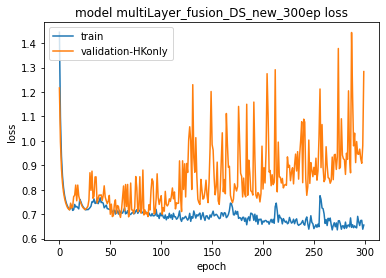

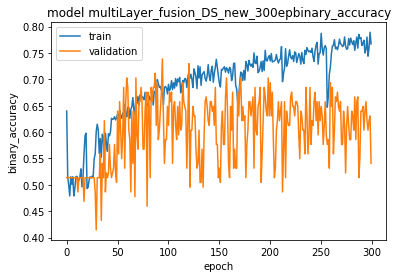

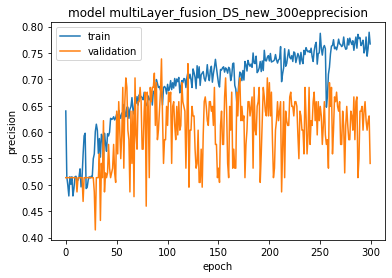

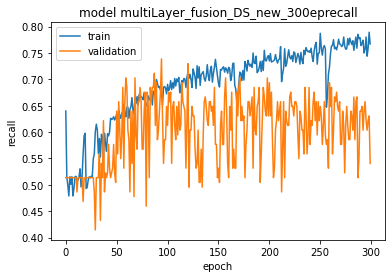

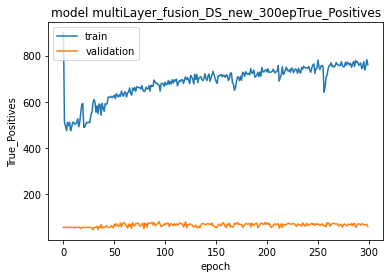

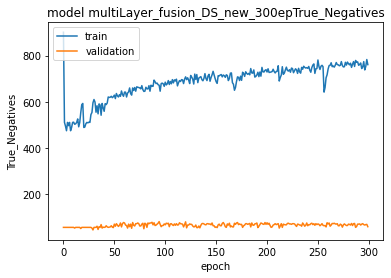

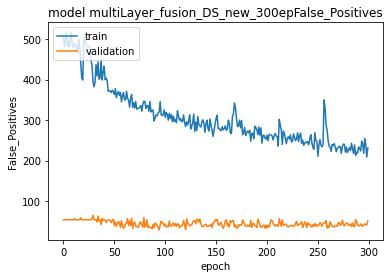

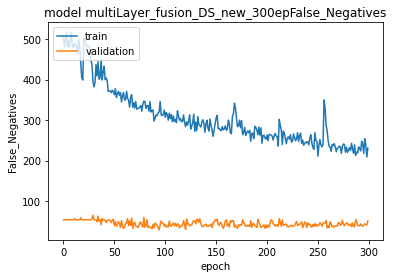

INFO:tensorflow:Assets written to: MultilayerFusion\OUTPUTS\MODELS-PB\multiLayer_fusion_DS_new_300ep\assets


In [123]:
printAndSaveGraphs(graphPath,'multiLayer_fusion_DS_new_300ep',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)

# save to csv: 
hist_csv_file = graphPath / Path('history_multiLayer_fusion_DS_new_300ep.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / Path('multiLayer_fusion_DS_new_300ep'))

In [124]:
bestPt = 'MultilayerFusion/callbacks/model_DS_DECISION_FUSION'
model = tf.keras.models.load_model(bestPt)

evaluation = model.evaluate(x = X_valIMG, y = Y_val)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_DS_ON_MASSES_OUTPUT_EACH_LR_90_10.txt', 'w') as f:
    f.write('CNN FUSION BY DS ON MASSES OF OUTPUT OF EACH LAYER TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')

4/4 [==============================] - 1s 82ms/step - loss: 0.7057 - binary_accuracy: 0.7387 - precision: 0.7387 - recall: 0.7387 - True_Positives: 82.0000 - True_Negatives: 82.0000 - False_Positives: 29.0000 - False_Negatives: 29.0000
{'loss': 0.7056899070739746, 'binary_accuracy': 0.7387387156486511, 'precision': 0.7387387156486511, 'recall': 0.7387387156486511, 'True_Positives': 82.0, 'True_Negatives': 82.0, 'False_Positives': 29.0, 'False_Negatives': 29.0}


## FIT WITH CROSS VALIDATION

In [ ]:
# VALIDATION_ACCURACY = []
# VALIDATION_LOSS = []

# save_dir = 'MultilayerFusion/saved_models/'
# fold_var = 1

# for train_index, val_index in kf.split(np.zeros(X_full.size),Y_full):
# # for train_index, val_index in kf.split(np.zeros(50),Y_full[:50]):

# 	training_data = COVID19_dataHK.iloc[train_index]
# 	validation_data = COVID19_dataHK.iloc[val_index]

# 	X_trainIMG = loadPNGtoArray(training_data['ImageFile'],basePath=databasePathIMAGES)
# 	X_valIMG = loadPNGtoArray(validation_data['ImageFile'],basePath=databasePathIMAGES)
	
# 	# train_data_generator = idg.flow_from_dataframe(training_data, directory = databasePathIMAGES,
# 	# 					       x_col = 'ImageFile', y_col = ['MILD','SEVERE'],
# 	# 					       class_mode = "raw",seed=42, shuffle = True, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[0]))
# 	# valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = databasePathIMAGES,
# 	# 						x_col = 'ImageFile', y_col = ['MILD','SEVERE'],
# 	# 						class_mode = "raw",seed=42, shuffle = True, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[0]))
# 	train_data_generator = idg.flow(X_trainIMG, y = training_data[['MILD','SEVERE']],
# 						       seed=42, shuffle = True)
# 	valid_data_generator = idg.flow(X_valIMG, y = validation_data[['MILD','SEVERE']],
# 						       seed=42, shuffle = True)

# 	# CREATE NEW MODEL
# 	model = DSfusionML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')
# 	# COMPILE NEW MODEL
# 	model.compile(loss='categorical_crossentropy',
# 		      optimizer=tf.keras.optimizers.Adam(),
# 		      metrics=METRICS)
# 	modelNumb = 0
# 	# CREATE CALLBACKS
# 	checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 							save_dir+'model_DS_callback_'+str(fold_var), 
# 							monitor='val_binary_accuracy', verbose=1, 
# 							save_best_only=True, mode='max')

# 	callbacks_list = [checkpoint]
# 	# There can be other callbacks, but just showing one because it involves the model name
# 	# This saves the best model
# 	# FIT THE MODEL
# 	history = model.fit(train_data_generator,
# 			    epochs=150,
# 			    callbacks=callbacks_list,
# 			    validation_data=valid_data_generator)
	
# 	#PLOT HISTORY
# 	printAndSaveGraphs(graphPath,'mlfusionCrossV10'+str(fold_var),history=history, Metrics=METRICS)
	
# 	# hist_df = pd.DataFrame(history.history)
# 	# save to csv: 
# 	# hist_csv_file = graphPath / Path('history_mlfusionCrossV10'+str(fold_var)+'.csv')
# 	# with open(hist_csv_file, mode='w') as f:
# 	#     hist_df.to_csv(f)

# 	# LOAD BEST MODEL to evaluate the performance of the model
# 	model.load_weights(save_dir+'model_DS_callback_'+str(fold_var))
	
# 	results = model.evaluate(valid_data_generator)
# 	results = dict(zip(model.metrics_names,results))
	
# 	VALIDATION_ACCURACY.append(results['binary_accuracy'])
# 	VALIDATION_LOSS.append(results['loss'])
	
# 	tf.keras.backend.clear_session()
	
# 	fold_var = fold_var + 1

In [ ]:
# print(VALIDATION_ACCURACY)

### RESNET50

In [59]:
from tensorflow.keras.applications import ResNet50V2

In [60]:
def createRes50Model(inputShape = (IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid'):
    inputT = Input(shape=inputShape)
    res50model = ResNet50V2(
        include_top=False,
        pooling='max',
        weights='imagenet',
        input_tensor = inputT,
        )
    out=res50model.output
    out=Dropout(0.5)(out)
    out=Dense(256)(out) 
    out = layers.LeakyReLU(alpha=0.1)(out)
    out = Dropout(0.25)(out)
    output = Dense(2, activation=lastActivation)(out)

    res50model = Model(inputs = res50model.input, outputs = output)
    return res50model

In [276]:
model = createRes50Model((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [277]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

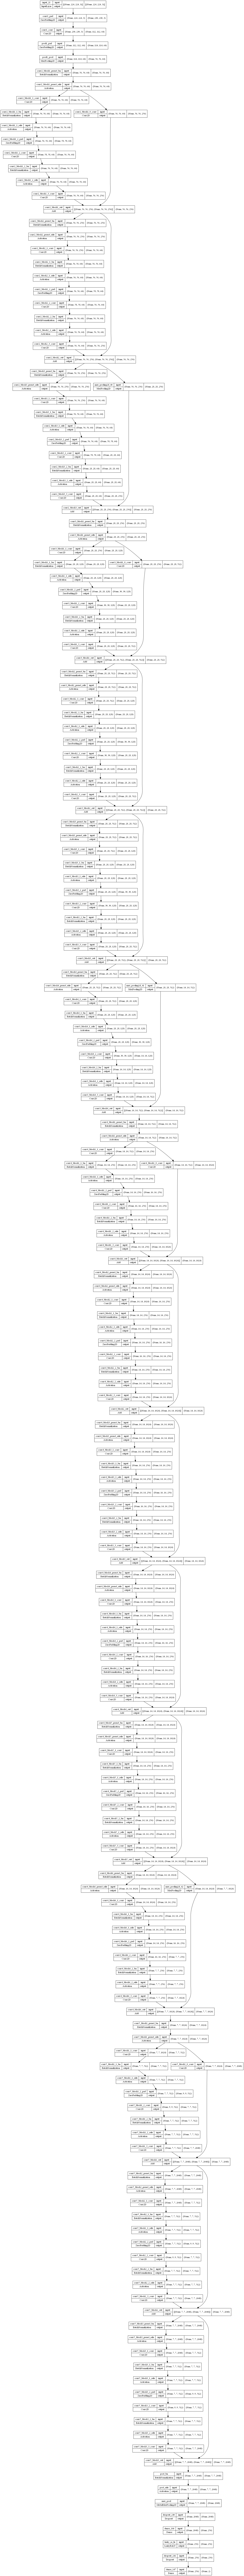

In [278]:
plot_model(model, to_file=plotpath / Path('RESNET50.png'), show_shapes=True, show_layer_names=True)

In [279]:
# def decay_lrate(initial_lrate, decay, iteration):
# 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

model.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),
        optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        loss="binary_crossentropy",
        metrics=METRICS,
)

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						'MultilayerFusion/callbacks/RESNET50_callb', 
						monitor='val_binary_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/model_DS_callback_DS', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
        x = X_trainIMG,
        y = Y_train,
        epochs = 200,
        validation_data = [X_valIMG,Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
)
# history = model.fit(
#         x = train_data_generator,
#         epochs = 200,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/200
31/31 [==============================] - ETA: 0s - loss: 2.2335 - binary_accuracy: 0.5190 - precision: 0.5182 - recall: 0.5413 - True_Positives: 597.0000 - True_Negatives: 548.0000 - False_Positives: 555.0000 - False_Negatives: 506.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.51351, saving model to MultilayerFusion/callbacks\RESNET50_callb
INFO:tensorflow:Assets written to: MultilayerFusion/callbacks\RESNET50_callb\assets
31/31 [==============================] - 14s 361ms/step - loss: 2.2335 - binary_accuracy: 0.5190 - precision: 0.5182 - recall: 0.5413 - True_Positives: 597.0000 - True_Negatives: 548.0000 - False_Positives: 555.0000 - False_Negatives: 506.0000 - val_loss: 653.4094 - val_binary_accuracy: 0.5135 - val_precision: 0.5135 - val_recall: 0.5135 - val_True_Positives: 57.0000 - val_True_Negatives: 57.0000 - val_False_Positives: 54.0000 - val_False_Negatives: 54.0000
Epoch 2/200
31/31 [==============================] - ETA: 0s - loss: 1.0941 - binary_ac

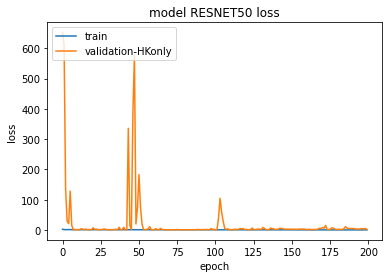

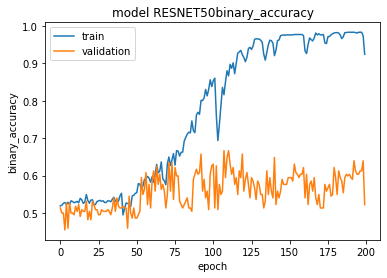

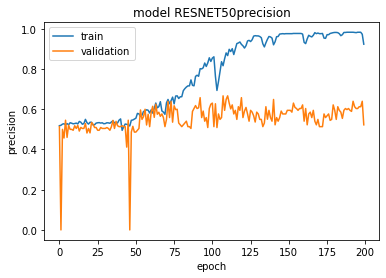

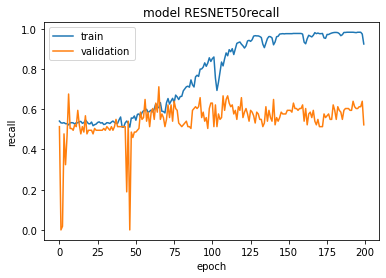

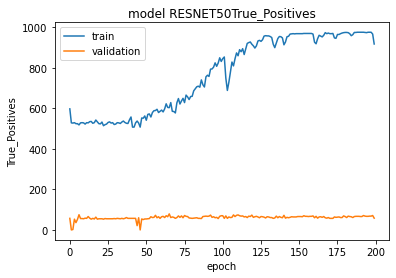

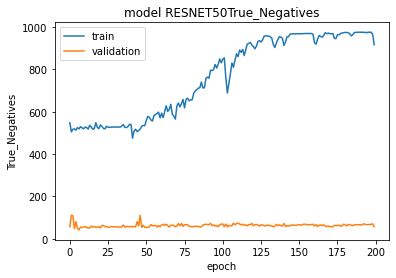

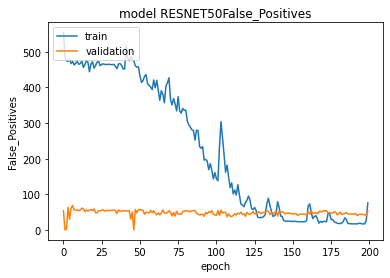

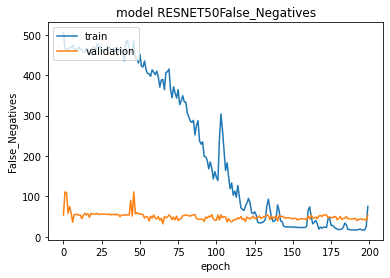

INFO:tensorflow:Assets written to: MultilayerFusion\OUTPUTS\MODELS-PB\RESNET50\assets


In [280]:
printAndSaveGraphs(graphPath,'RESNET50',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)

# save to csv: 
hist_csv_file = graphPath / Path('RESNET50.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
model.save(pathSavedModel / Path('RESNET50'))

In [281]:
bestPt = 'MultilayerFusion/callbacks/RESNET50_callb'
model = tf.keras.models.load_model(bestPt)

evaluation = model.evaluate(x = X_valIMG, y = Y_val)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_RESNET50V2_90_10.txt', 'w') as f:
    f.write('CNN RESNET50V2 TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')

4/4 [==============================] - 1s 72ms/step - loss: 1.6728 - binary_accuracy: 0.6667 - precision: 0.6667 - recall: 0.6667 - True_Positives: 74.0000 - True_Negatives: 74.0000 - False_Positives: 37.0000 - False_Negatives: 37.0000
{'loss': 1.6728315353393555, 'binary_accuracy': 0.6666666865348816, 'precision': 0.6666666865348816, 'recall': 0.6666666865348816, 'True_Positives': 74.0, 'True_Negatives': 74.0, 'False_Positives': 37.0, 'False_Negatives': 37.0}


## CROSS FOLD VALIDATION

10 fold validation

In [49]:
from sklearn.model_selection import KFold, StratifiedKFold

In [50]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix

In [51]:
from statistics import mean

In [52]:
def changeModelLayers(model, addname):
    for layer in model.layers:
        layer._name = layer.name + str(addname)
    return model

### fn
Function for cross n-Fold validation
input: (Model, Input feature DB, Labels DB, namel of the architecture for saving, path for saving, number of FOLD VALIDATION, epochs per validation, optimizer for the model)

In [91]:
def executeFoldValidationOnModel(model, X,Y,architectureName='kFoldVal',pathForKfold=Path('Multilayer/KFoldVal'),kfold = 10, epochs = 300, optim = tf.keras.optimizers.Adam()):
    #kf definition
    kf = KFold(n_splits = kfold, shuffle=True, random_state=42)
    # kf = KFold(n_splits = kfold)
    
    VAL_ACCURACY = []
    VAL_RECALL = []
    VAL_PRECISION = []
    VAL_FP = []
    VAL_TP = []
    VAL_TN = []
    VAL_FN = []
    VAL_LOSS = []

    VAL_ACCURACY_SK = []
    VAL_RECALL_SK = []
    VAL_PRECISION_SK = []
    VAL_CM_SK = []
    VAL_LOSS_SK = []
    
    save_dir = pathForKfold
    fold_var = 1

    baseModelPath = pathForKfold / Path('baseModelNotTrained')
    model.save(baseModelPath)

    
    for train_index, val_index in kf.split(X,Y):

        if fold_var<20:
            
            training_data = COVID19_dataHK.iloc[train_index]
            validation_data = COVID19_dataHK.iloc[val_index]


            X_trainIMG = loadPNGtoArray(training_data['ImageFile'],basePath=databasePathIMAGES)
            y_train = Y.iloc[train_index]
            X_valIMG = loadPNGtoArray(validation_data['ImageFile'],basePath=databasePathIMAGES)
            y_val = Y.iloc[val_index]

            # LOAD BEST MODEL to evaluate the performance of the model
            # model.load_weights(str(save_dir /Path('OLD') / architectureName)  +'_'+ str(fold_var))
            model.load_weights(str(save_dir / architectureName)  +'_'+ str(fold_var))

            model.compile(optimizer=optim,
                loss="binary_crossentropy",
                metrics=METRICS,
                )

            results = model.evaluate(x=X_valIMG,y=y_val)
            results = dict(zip(model.metrics_names,results))
            VAL_ACCURACY.append(results['binary_accuracy'])
            VAL_RECALL.append(results['recall'])
            VAL_PRECISION.append(results['precision'])
            VAL_FP.append(results['False_Positives'])
            VAL_TP.append(results['True_Positives'])
            VAL_TN.append(results['True_Negatives'])
            VAL_FN.append(results['False_Negatives'])
            VAL_LOSS.append(results['loss'])
    
            p = model.predict(X_valIMG)
    
            ypreds = np.argmax(p, axis=1)
            yground = np.argmax(y_val.to_numpy(), axis=1)
            loss = log_loss(yground, ypreds)
            # print('log_loss: ', loss)
            accuracy = accuracy_score(yground, ypreds)
            # print('accuracy: ', accuracy)
            precision = precision_score(yground, ypreds)
            # print('precision: ', precision)
            recall = recall_score(yground, ypreds)
            # print('recall: ', recall)
            cmatrix = confusion_matrix(yground, ypreds)
            # print(cmatrix)
    
            VAL_ACCURACY_SK.append(accuracy)
            VAL_RECALL_SK.append(recall)
            VAL_PRECISION_SK.append(precision)
            VAL_CM_SK.append(cmatrix)
            VAL_LOSS_SK.append(loss)  
    
            tf.keras.backend.clear_session()
            
            fold_var = fold_var + 1


        else:

            training_data = COVID19_dataHK.iloc[train_index]
            validation_data = COVID19_dataHK.iloc[val_index]


            X_trainIMG = loadPNGtoArray(training_data['ImageFile'],basePath=databasePathIMAGES)
            y_train = Y.iloc[train_index]
            X_valIMG = loadPNGtoArray(validation_data['ImageFile'],basePath=databasePathIMAGES)
            y_val = Y.iloc[val_index]

            model = tf.keras.models.load_model(baseModelPath)

            # model = changeModelLayers(model,architectureName+'model_n_'+str(fold_var))

            model.compile(optimizer=optim,
                            loss="binary_crossentropy",
                            metrics=METRICS,
                            )

    	    # CREATE CALLBACKS
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
    	    						str(save_dir / architectureName)  +'_'+ str(fold_var), 
    	    						monitor='val_binary_accuracy', verbose=1, 
    	    						save_best_only=True, mode='max')
            callbacks_list = [checkpoint]
    	    # There can be other callbacks, but just showing one because it involves the model name
    	    # This saves the best model
    	    # FIT THE MODEL
            history = model.fit(
                        x = X_trainIMG,
                        y = y_train,
    	    		    epochs=epochs,
    	    		    callbacks=callbacks_list,
    	    		    validation_data=[X_valIMG,y_val])
    	    #PLOT HISTORY
            printAndSaveGraphs(save_dir,architectureName+'_'+str(fold_var),history=history, Metrics=METRICS)

    	    # LOAD BEST MODEL to evaluate the performance of the model
            model.load_weights(str(save_dir / architectureName)  +'_'+ str(fold_var))
            results = model.evaluate(x=X_valIMG,y=y_val)
            results = dict(zip(model.metrics_names,results))
            VAL_ACCURACY.append(results['binary_accuracy'])
            VAL_RECALL.append(results['recall'])
            VAL_PRECISION.append(results['precision'])
            VAL_FP.append(results['False_Positives'])
            VAL_TP.append(results['True_Positives'])
            VAL_TN.append(results['True_Negatives'])
            VAL_FN.append(results['False_Negatives'])
            VAL_LOSS.append(results['loss'])
    
            p = model.predict(X_valIMG)
    
            ypreds = np.argmax(p, axis=1)
            yground = np.argmax(y_val.to_numpy(), axis=1)
            loss = log_loss(yground, ypreds)
            # print('log_loss: ', loss)
            accuracy = accuracy_score(yground, ypreds)
            # print('accuracy: ', accuracy)
            precision = precision_score(yground, ypreds)
            # print('precision: ', precision)
            recall = recall_score(yground, ypreds)
            # print('recall: ', recall)
            cmatrix = confusion_matrix(yground, ypreds)
            # print(cmatrix)
    
            VAL_ACCURACY_SK.append(accuracy)
            VAL_RECALL_SK.append(recall)
            VAL_PRECISION_SK.append(precision)
            VAL_CM_SK.append(cmatrix)
            VAL_LOSS_SK.append(loss)  
    
            tf.keras.backend.clear_session()
            
            fold_var = fold_var + 1
    
    return VAL_LOSS,VAL_ACCURACY,VAL_RECALL,VAL_PRECISION,VAL_TP,VAL_TN,VAL_FP,VAL_FN,VAL_LOSS_SK, VAL_ACCURACY_SK,VAL_RECALL_SK,VAL_PRECISION_SK,VAL_CM_SK

### RESNET 50 10-Fold-Val

In [62]:
model = createRes50Model((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [63]:
LO,AC,RC,PR,TP,TN,FP,FN,LOsk,ACsk,RCsk,PRsk,CMsk = executeFoldValidationOnModel(model,X_full,Y_full,epochs=200, architectureName='Resnet50')

INFO:tensorflow:Assets written to: Multilayer\KFoldVal\baseModelNotTrained\assets


100%|██████████| 111/111 [00:05<00:00, 19.45it/s]


4/4 [==============================] - 2s 109ms/step - loss: 0.9438 - binary_accuracy: 0.7081 - precision: 0.7091 - recall: 0.7059 - True_Positives: 156.0000 - True_Negatives: 157.0000 - False_Positives: 64.0000 - False_Negatives: 65.0000


100%|██████████| 111/111 [00:04<00:00, 22.56it/s]


4/4 [==============================] - 1s 23ms/step - loss: 0.6616 - binary_accuracy: 0.6807 - precision: 0.6818 - recall: 0.6777 - True_Positives: 225.0000 - True_Negatives: 227.0000 - False_Positives: 105.0000 - False_Negatives: 107.0000


100%|██████████| 111/111 [00:06<00:00, 17.60it/s]


4/4 [==============================] - 1s 23ms/step - loss: 1.0468 - binary_accuracy: 0.6512 - precision: 0.6502 - recall: 0.6546 - True_Positives: 290.0000 - True_Negatives: 287.0000 - False_Positives: 156.0000 - False_Negatives: 153.0000


100%|██████████| 110/110 [00:06<00:00, 16.11it/s]


4/4 [==============================] - 1s 105ms/step - loss: 1.3170 - binary_accuracy: 0.6347 - precision: 0.6342 - recall: 0.6365 - True_Positives: 352.0000 - True_Negatives: 350.0000 - False_Positives: 203.0000 - False_Negatives: 201.0000


100%|██████████| 110/110 [00:05<00:00, 21.38it/s]


4/4 [==============================] - 1s 23ms/step - loss: 39.4285 - binary_accuracy: 0.6275 - precision: 0.6290 - recall: 0.6214 - True_Positives: 412.0000 - True_Negatives: 420.0000 - False_Positives: 243.0000 - False_Negatives: 251.0000


100%|██████████| 110/110 [00:05<00:00, 20.03it/s]


4/4 [==============================] - 1s 24ms/step - loss: 0.6844 - binary_accuracy: 0.6229 - precision: 0.6237 - recall: 0.6197 - True_Positives: 479.0000 - True_Negatives: 484.0000 - False_Positives: 289.0000 - False_Negatives: 294.0000


100%|██████████| 110/110 [00:05<00:00, 19.40it/s]


4/4 [==============================] - 1s 23ms/step - loss: 0.6802 - binary_accuracy: 0.6246 - precision: 0.6250 - recall: 0.6229 - True_Positives: 550.0000 - True_Negatives: 553.0000 - False_Positives: 330.0000 - False_Negatives: 333.0000


100%|██████████| 110/110 [00:06<00:00, 18.06it/s]


4/4 [==============================] - 1s 23ms/step - loss: 1.0258 - binary_accuracy: 0.6244 - precision: 0.6296 - recall: 0.6042 - True_Positives: 600.0000 - True_Negatives: 640.0000 - False_Positives: 353.0000 - False_Negatives: 393.0000


100%|██████████| 110/110 [00:06<00:00, 16.62it/s]


4/4 [==============================] - 1s 22ms/step - loss: 0.9157 - binary_accuracy: 0.6160 - precision: 0.6203 - recall: 0.5984 - True_Positives: 660.0000 - True_Negatives: 699.0000 - False_Positives: 404.0000 - False_Negatives: 443.0000


100%|██████████| 110/110 [00:05<00:00, 20.25it/s]


4/4 [==============================] - 1s 22ms/step - loss: 0.7293 - binary_accuracy: 0.6208 - precision: 0.6249 - recall: 0.6043 - True_Positives: 733.0000 - True_Negatives: 773.0000 - False_Positives: 440.0000 - False_Negatives: 480.0000


In [64]:
print('Evaluation of the model in 10 fold cross validation: ')
print('loss:')
print('Keras:    '+str(LO)+'   SKlearn:    '+str(LOsk))
print('accuracy:')
print('Keras:    '+str(AC)+'   SKlearn:    '+str(ACsk))
print('recall:')
print('Keras:    '+str(RC)+'   SKlearn:    '+str(RCsk))
print('precision:')
print('Keras:    '+str(PR)+'   SKlearn:    '+str(PRsk))
print('true positives:')
print(TP)
print('true negatives:')
print(TN)
print('false positives:')
print(FP)
print('false negatives:')
print(FN)
print('CONFUSION MATRIX:')
print(CMsk)

Evaluation of the model in 10 fold cross validation: 
loss:
Keras:    [0.9437664151191711, 0.6615567803382874, 1.046819806098938, 1.3169952630996704, 39.428524017333984, 0.6843576431274414, 0.6801551580429077, 1.0257799625396729, 0.9156506061553955, 0.7292838096618652]   SKlearn:    [10.26840013144987, 12.757746145289124, 15.247149787771995, 14.757738873348082, 13.501594372322375, 14.12981200418617, 12.873762001038576, 12.559787662856305, 16.013788876495674, 11.61782830297174]
accuracy:
Keras:    [0.7081447839736938, 0.6807228922843933, 0.6512415409088135, 0.634719729423523, 0.6274510025978088, 0.6228978037834167, 0.6245753169059753, 0.6243705749511719, 0.6160471439361572, 0.6207749247550964]   SKlearn:    [0.7027027027027027, 0.6306306306306306, 0.5585585585585585, 0.5727272727272728, 0.6090909090909091, 0.5909090909090909, 0.6272727272727273, 0.6363636363636364, 0.5363636363636364, 0.6636363636363637]
recall:
Keras:    [0.7058823704719543, 0.6777108311653137, 0.6546275615692139, 0.63

In [65]:
print('loss_mean:')
print('Keras:    '+str(mean(LO))+'   SKlearn:    '+str(mean(LOsk)))
print('accuracy_mean:')
print('Keras:    '+str(mean(AC))+'   SKlearn:    '+str(mean(ACsk)))
print('recall_mean:')
print('Keras:    '+str(mean(RC))+'   SKlearn:    '+str(mean(RCsk)))
print('precision_mean:')
print('Keras:    '+str(mean(PR))+'   SKlearn:    '+str(mean(PRsk)))
print('true positives_mean:')
print(mean(TP))
print('true negatives_mean:')
print(mean(TN))
print('false positives_mean:')
print(mean(FP))
print('false negatives_mean:')
print(mean(FN))

loss_mean:
Keras:    4.743288946151734   SKlearn:    13.372760815772992
accuracy_mean:
Keras:    0.641094571352005   SKlearn:    0.6128255528255528
recall_mean:
Keras:    0.6345591485500336   SKlearn:    0.7997706332620126
precision_mean:
Keras:    0.6427858054637909   SKlearn:    0.6020637163002855
true positives_mean:
445.7
true negatives_mean:
459.0
false positives_mean:
258.7
false negatives_mean:
272.0


In [67]:
lines = ['RESNET 50 V2','','Evaluation of the model in 10 fold cross validation: ','loss:',str(LO),'accuracy:',str(AC),'recall:',str(RC),'precision:',str(PR),'true positives:',str(TP),'true negatives:',str(TN),'false positives:',str(FP),'false negatives:',str(FN),
        '','MEANS: ','loss:',str(mean(LO)),'accuracy:',str(mean(AC)),'recall:',str(mean(RC)),'precision:',str(mean(PR)),'true positives:',str(mean(TP)),'true negatives:',str(mean(TN)),'false positives:',str(mean(FP)),'false negatives:',str(mean(FN)),
        '','SKLEARN:','','loss:',str(LOsk),'accuracy:',str(ACsk),'recall:',str(RCsk),'precision:',str(PRsk),'true positives:','confusion matrix',str(CMsk),
        '','MEANS: ','loss:',str(mean(LOsk)),'accuracy:',str(mean(ACsk)),'recall:',str(mean(RCsk)),'precision:',str(mean(PRsk)),
        ]
with open('Multilayer/KFoldVal/RESNET50V2_evalutation.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

### Multilayer fusion with DS 10-Fold-Val

In [78]:
model = DSfusionML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [79]:
LO,AC,RC,PR,TP,TN,FP,FN,LOsk,ACsk,RCsk,PRsk,CMsk = executeFoldValidationOnModel(model,X_full,Y_full,epochs=300, architectureName='DSmultilayerFusion',optim=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5))

print(AC)
print(LO)

INFO:tensorflow:Assets written to: Multilayer\KFoldVal\baseModelNotTrained\assets


100%|██████████| 111/111 [00:06<00:00, 17.69it/s]


Epoch 1/300


In [ ]:
print('Evaluation of the model in 10 fold cross validation: ')
print('loss:')
print('Keras:    '+str(LO)+'   SKlearn:    '+str(LOsk))
print('accuracy:')
print('Keras:    '+str(AC)+'   SKlearn:    '+str(ACsk))
print('recall:')
print('Keras:    '+str(RC)+'   SKlearn:    '+str(RCsk))
print('precision:')
print('Keras:    '+str(PR)+'   SKlearn:    '+str(PRsk))
print('true positives:')
print(TP)
print('true negatives:')
print(TN)
print('false positives:')
print(FP)
print('false negatives:')
print(FN)
print('CONFUSION MATRIX:')
print(CMsk)

In [ ]:
print('loss_mean:')
print('Keras:    '+str(mean(LO))+'   SKlearn:    '+str(mean(LOsk)))
print('accuracy_mean:')
print('Keras:    '+str(mean(AC))+'   SKlearn:    '+str(mean(ACsk)))
print('recall_mean:')
print('Keras:    '+str(mean(RC))+'   SKlearn:    '+str(mean(RCsk)))
print('precision_mean:')
print('Keras:    '+str(mean(PR))+'   SKlearn:    '+str(mean(PRsk)))
print('true positives_mean:')
print(mean(TP))
print('true negatives_mean:')
print(mean(TN))
print('false positives_mean:')
print(mean(FP))
print('false negatives_mean:')
print(mean(FN))

In [ ]:
lines = ['MULTILAYER FUSION FEATURE ON CNN DS (OLD)','','Evaluation of the model in 10 fold cross validation: ','loss:',str(LO),'accuracy:',str(AC),'recall:',str(RC),'precision:',str(PR),'true positives:',str(TP),'true negatives:',str(TN),'false positives:',str(FP),'false negatives:',str(FN),
        '','MEANS: ','loss:',str(mean(LO)),'accuracy:',str(mean(AC)),'recall:',str(mean(RC)),'precision:',str(mean(PR)),'true positives:',str(mean(TP)),'true negatives:',str(mean(TN)),'false positives:',str(mean(FP)),'false negatives:',str(mean(FN)),
        '','SKLEARN:','','loss:',str(LOsk),'accuracy:',str(ACsk),'recall:',str(RCsk),'precision:',str(PRsk),'true positives:','confusion matrix',str(CMsk),
        '','MEANS: ','loss:',str(mean(LOsk)),'accuracy:',str(mean(ACsk)),'recall:',str(mean(RCsk)),'precision:',str(mean(PRsk)),'confusion matrix:',str(mean(CMsk)),
        ]
with open('Multilayer/KFoldVal/DSmultilayerFusion_evalutation.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

### Multilayer fusion Concatenation 10-Fold-Val

In [70]:
model = DSfusionConc((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [71]:
LO,AC,RC,PR,TP,TN,FP,FN,LOsk,ACsk,RCsk,PRsk,CMsk = executeFoldValidationOnModel(model,X_full,Y_full,epochs=300, architectureName='MultilayerfusionCONCAT',optim=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5))

INFO:tensorflow:Assets written to: Multilayer\KFoldVal\baseModelNotTrained\assets


100%|██████████| 111/111 [00:05<00:00, 19.61it/s]


4/4 [==============================] - 1s 51ms/step - loss: 1.2893 - binary_accuracy: 0.6110 - precision: 0.6145 - recall: 0.5959 - True_Positives: 789.0000 - True_Negatives: 829.0000 - False_Positives: 495.0000 - False_Negatives: 535.0000


100%|██████████| 111/111 [00:04<00:00, 22.46it/s]


4/4 [==============================] - 1s 74ms/step - loss: 1.1077 - binary_accuracy: 0.6042 - precision: 0.6072 - recall: 0.5902 - True_Positives: 847.0000 - True_Negatives: 887.0000 - False_Positives: 548.0000 - False_Negatives: 588.0000


100%|██████████| 111/111 [00:06<00:00, 17.51it/s]


4/4 [==============================] - 1s 56ms/step - loss: 1.0093 - binary_accuracy: 0.5983 - precision: 0.6009 - recall: 0.5854 - True_Positives: 905.0000 - True_Negatives: 945.0000 - False_Positives: 601.0000 - False_Negatives: 641.0000


100%|██████████| 110/110 [00:06<00:00, 15.96it/s]


4/4 [==============================] - 1s 59ms/step - loss: 1.3209 - binary_accuracy: 0.5924 - precision: 0.5947 - recall: 0.5803 - True_Positives: 961.0000 - True_Negatives: 1001.0000 - False_Positives: 655.0000 - False_Negatives: 695.0000


C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 110/110 [00:05<00:00, 21.37it/s]


4/4 [==============================] - 1s 49ms/step - loss: 1.0751 - binary_accuracy: 0.5872 - precision: 0.5892 - recall: 0.5759 - True_Positives: 1017.0000 - True_Negatives: 1057.0000 - False_Positives: 709.0000 - False_Negatives: 749.0000


100%|██████████| 110/110 [00:05<00:00, 20.31it/s]


4/4 [==============================] - 0s 20ms/step - loss: 0.9754 - binary_accuracy: 0.5848 - precision: 0.5866 - recall: 0.5741 - True_Positives: 1077.0000 - True_Negatives: 1117.0000 - False_Positives: 759.0000 - False_Negatives: 799.0000


100%|██████████| 110/110 [00:05<00:00, 19.49it/s]


4/4 [==============================] - 1s 41ms/step - loss: 1.4447 - binary_accuracy: 0.5856 - precision: 0.5874 - recall: 0.5755 - True_Positives: 1143.0000 - True_Negatives: 1183.0000 - False_Positives: 803.0000 - False_Negatives: 843.0000


C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 110/110 [00:06<00:00, 17.96it/s]


4/4 [==============================] - 1s 48ms/step - loss: 1.0359 - binary_accuracy: 0.5849 - precision: 0.5866 - recall: 0.5754 - True_Positives: 1206.0000 - True_Negatives: 1246.0000 - False_Positives: 850.0000 - False_Negatives: 890.0000


100%|██████████| 110/110 [00:06<00:00, 16.69it/s]


4/4 [==============================] - 1s 33ms/step - loss: 1.4591 - binary_accuracy: 0.5807 - precision: 0.5822 - recall: 0.5716 - True_Positives: 1261.0000 - True_Negatives: 1301.0000 - False_Positives: 905.0000 - False_Negatives: 945.0000


C:\Users\Michele\anaconda3\envs\tfGPU\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 110/110 [00:05<00:00, 20.12it/s]


4/4 [==============================] - 1s 46ms/step - loss: 0.7128 - binary_accuracy: 0.5807 - precision: 0.5822 - recall: 0.5721 - True_Positives: 1325.0000 - True_Negatives: 1365.0000 - False_Positives: 951.0000 - False_Negatives: 991.0000


In [72]:
print('Evaluation of the model in 10 fold cross validation: ')
print('loss:')
print('Keras:    '+str(LO)+'   SKlearn:    '+str(LOsk))
print('accuracy:')
print('Keras:    '+str(AC)+'   SKlearn:    '+str(ACsk))
print('recall:')
print('Keras:    '+str(RC)+'   SKlearn:    '+str(RCsk))
print('precision:')
print('Keras:    '+str(PR)+'   SKlearn:    '+str(PRsk))
print('true positives:')
print(TP)
print('true negatives:')
print(TN)
print('false positives:')
print(FP)
print('false negatives:')
print(FN)
print('CONFUSION MATRIX:')
print(CMsk)

Evaluation of the model in 10 fold cross validation: 
loss:
Keras:    [1.289270043373108, 1.107662320137024, 1.0093306303024292, 1.3209412097930908, 1.0751490592956543, 0.9753697514533997, 1.4446749687194824, 1.0358879566192627, 1.4591318368911743, 0.7127901911735535]   SKlearn:    [17.11420432052926, 16.49186961796456, 16.49186961796456, 16.95539932113797, 16.95579185078552, 15.699807269245852, 13.815510557964275, 14.7578188330911, 17.26938819745534, 14.443822687706183]
accuracy:
Keras:    [0.611027181148529, 0.604181170463562, 0.5983182191848755, 0.592391312122345, 0.5872027277946472, 0.5847548246383667, 0.5855991840362549, 0.5849236845970154, 0.580689013004303, 0.5807426571846008]   SKlearn:    [0.5045045045045045, 0.5225225225225225, 0.5225225225225225, 0.509090909090909, 0.509090909090909, 0.5454545454545454, 0.6, 0.5727272727272728, 0.5, 0.5818181818181818]
recall:
Keras:    [0.5959214568138123, 0.5902438759803772, 0.5853816270828247, 0.5803139805793762, 0.5758776664733887, 0.574

In [73]:
print('loss_mean:')
print('Keras:    '+str(mean(LO))+'   SKlearn:    '+str(mean(LOsk)))
print('accuracy_mean:')
print('Keras:    '+str(mean(AC))+'   SKlearn:    '+str(mean(ACsk)))
print('recall_mean:')
print('Keras:    '+str(mean(RC))+'   SKlearn:    '+str(mean(RCsk)))
print('precision_mean:')
print('Keras:    '+str(mean(PR))+'   SKlearn:    '+str(mean(PRsk)))
print('true positives_mean:')
print(mean(TP))
print('true negatives_mean:')
print(mean(TN))
print('false positives_mean:')
print(mean(FP))
print('false negatives_mean:')
print(mean(FN))

loss_mean:
Keras:    1.143020796775818   SKlearn:    15.999548227384462
accuracy_mean:
Keras:    0.59098299741745   SKlearn:    0.5367731367731368
recall_mean:
Keras:    0.5796472728252411   SKlearn:    0.7
precision_mean:
Keras:    0.5931362569332123   SKlearn:    0.37586404586404587
true positives_mean:
1053.1
true negatives_mean:
1093.1
false positives_mean:
727.6
false negatives_mean:
767.6


In [74]:
lines = ['MULTILAYER FUSION BY CONCATENATION','','Evaluation of the model in 10 fold cross validation: ','loss:',str(LO),'accuracy:',str(AC),'recall:',str(RC),'precision:',str(PR),'true positives:',str(TP),'true negatives:',str(TN),'false positives:',str(FP),'false negatives:',str(FN),
        '','MEANS: ','loss:',str(mean(LO)),'accuracy:',str(mean(AC)),'recall:',str(mean(RC)),'precision:',str(mean(PR)),'true positives:',str(mean(TP)),'true negatives:',str(mean(TN)),'false positives:',str(mean(FP)),'false negatives:',str(mean(FN)),
        '','SKLEARN:','','loss:',str(LOsk),'accuracy:',str(ACsk),'recall:',str(RCsk),'precision:',str(PRsk),'true positives:','confusion matrix',str(CMsk),
        '','MEANS: ','loss:',str(mean(LOsk)),'accuracy:',str(mean(ACsk)),'recall:',str(mean(RCsk)),'precision:',str(mean(PRsk)),
        ]
with open('Multilayer/KFoldVal/MultilayerFusionCONCAT_evalutation.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

### Multilayer fusion FUSION FEATURE DS 10-Fold-Val

In [92]:
prototypes = 32
model = DSfusionFeaturesML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [93]:
LO,AC,RC,PR,TP,TN,FP,FN,LOsk,ACsk,RCsk,PRsk,CMsk = executeFoldValidationOnModel(model,X_full,Y_full,epochs=300, architectureName='MultilayerFusionFeatureOnDense',optim=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5))

INFO:tensorflow:Assets written to: Multilayer\KFoldVal\baseModelNotTrained\assets


100%|██████████| 111/111 [00:05<00:00, 19.61it/s]


4/4 [==============================] - 4s 70ms/step - loss: 0.6993 - binary_accuracy: 0.6088 - precision: 0.6100 - recall: 0.6031 - True_Positives: 2129.0000 - True_Negatives: 2169.0000 - False_Positives: 1361.0000 - False_Negatives: 1401.0000


100%|██████████| 111/111 [00:05<00:00, 19.39it/s]


4/4 [==============================] - 3s 63ms/step - loss: 0.7396 - binary_accuracy: 0.6111 - precision: 0.6123 - recall: 0.6056 - True_Positives: 2205.0000 - True_Negatives: 2245.0000 - False_Positives: 1396.0000 - False_Negatives: 1436.0000


100%|██████████| 111/111 [00:05<00:00, 19.96it/s]


4/4 [==============================] - 3s 60ms/step - loss: 0.7712 - binary_accuracy: 0.6138 - precision: 0.6150 - recall: 0.6085 - True_Positives: 2283.0000 - True_Negatives: 2323.0000 - False_Positives: 1429.0000 - False_Negatives: 1469.0000


100%|██████████| 110/110 [00:05<00:00, 18.70it/s]


4/4 [==============================] - 3s 83ms/step - loss: 0.8943 - binary_accuracy: 0.6165 - precision: 0.6177 - recall: 0.6113 - True_Positives: 2361.0000 - True_Negatives: 2401.0000 - False_Positives: 1461.0000 - False_Negatives: 1501.0000


100%|██████████| 110/110 [00:05<00:00, 19.09it/s]


4/4 [==============================] - 4s 94ms/step - loss: 0.9209 - binary_accuracy: 0.6206 - precision: 0.6218 - recall: 0.6156 - True_Positives: 2445.0000 - True_Negatives: 2485.0000 - False_Positives: 1487.0000 - False_Negatives: 1527.0000


100%|██████████| 110/110 [00:05<00:00, 19.18it/s]


4/4 [==============================] - 4s 55ms/step - loss: 0.8872 - binary_accuracy: 0.6215 - precision: 0.6227 - recall: 0.6166 - True_Positives: 2517.0000 - True_Negatives: 2557.0000 - False_Positives: 1525.0000 - False_Negatives: 1565.0000


100%|██████████| 110/110 [00:05<00:00, 19.01it/s]


4/4 [==============================] - 4s 64ms/step - loss: 1.0727 - binary_accuracy: 0.6229 - precision: 0.6240 - recall: 0.6181 - True_Positives: 2591.0000 - True_Negatives: 2631.0000 - False_Positives: 1561.0000 - False_Negatives: 1601.0000


100%|██████████| 110/110 [00:06<00:00, 17.82it/s]


4/4 [==============================] - 4s 80ms/step - loss: 0.8141 - binary_accuracy: 0.6255 - precision: 0.6267 - recall: 0.6209 - True_Positives: 2671.0000 - True_Negatives: 2711.0000 - False_Positives: 1591.0000 - False_Negatives: 1631.0000


100%|██████████| 110/110 [00:06<00:00, 17.89it/s]


4/4 [==============================] - 4s 68ms/step - loss: 0.8137 - binary_accuracy: 0.6290 - precision: 0.6301 - recall: 0.6244 - True_Positives: 2755.0000 - True_Negatives: 2795.0000 - False_Positives: 1617.0000 - False_Negatives: 1657.0000


100%|██████████| 110/110 [00:06<00:00, 18.01it/s]


4/4 [==============================] - 4s 84ms/step - loss: 0.9401 - binary_accuracy: 0.6311 - precision: 0.6323 - recall: 0.6267 - True_Positives: 2834.0000 - True_Negatives: 2874.0000 - False_Positives: 1648.0000 - False_Negatives: 1688.0000


In [94]:
print('Evaluation of the model in 10 fold cross validation: ')
print('loss:')
print('Keras:    '+str(LO)+'   SKlearn:    '+str(LOsk))
print('accuracy:')
print('Keras:    '+str(AC)+'   SKlearn:    '+str(ACsk))
print('recall:')
print('Keras:    '+str(RC)+'   SKlearn:    '+str(RCsk))
print('precision:')
print('Keras:    '+str(PR)+'   SKlearn:    '+str(PRsk))
print('true positives:')
print(TP)
print('true negatives:')
print(TN)
print('false positives:')
print(FP)
print('false negatives:')
print(FN)
print('CONFUSION MATRIX:')
print(CMsk)

Evaluation of the model in 10 fold cross validation: 
loss:
Keras:    [0.6993246078491211, 0.7395607829093933, 0.7712246775627136, 0.8942825198173523, 0.9208768010139465, 0.8871551752090454, 1.072725772857666, 0.8140504360198975, 0.8136560320854187, 0.9401409029960632]   SKlearn:    [9.334883670441917, 10.890821276979995, 10.268385724288967, 10.047782154439231, 8.163827089332374, 11.93171541234345, 11.303781274113994, 9.419804401804493, 8.163841627467466, 9.733815085324505]
accuracy:
Keras:    [0.6087818741798401, 0.6110958456993103, 0.6138059496879578, 0.6165199279785156, 0.6205941438674927, 0.6215090751647949, 0.6228530406951904, 0.625523030757904, 0.6289664506912231, 0.6311366558074951]   SKlearn:    [0.7297297297297297, 0.6846846846846847, 0.7027027027027027, 0.7090909090909091, 0.7636363636363637, 0.6545454545454545, 0.6727272727272727, 0.7272727272727273, 0.7636363636363637, 0.7181818181818181]
recall:
Keras:    [0.6031161546707153, 0.6056028604507446, 0.6084755063056946, 0.61134

In [95]:
print('loss_mean:')
print('Keras:    '+str(mean(LO))+'   SKlearn:    '+str(mean(LOsk)))
print('accuracy_mean:')
print('Keras:    '+str(mean(AC))+'   SKlearn:    '+str(mean(ACsk)))
print('recall_mean:')
print('Keras:    '+str(mean(RC))+'   SKlearn:    '+str(mean(RCsk)))
print('precision_mean:')
print('Keras:    '+str(mean(PR))+'   SKlearn:    '+str(mean(PRsk)))
print('true positives_mean:')
print(mean(TP))
print('true negatives_mean:')
print(mean(TN))
print('false positives_mean:')
print(mean(FP))
print('false negatives_mean:')
print(mean(FN))

loss_mean:
Keras:    0.8552997708320618   SKlearn:    9.925865771653639
accuracy_mean:
Keras:    0.6200785994529724   SKlearn:    0.7126208026208026
recall_mean:
Keras:    0.6150807499885559   SKlearn:    0.7784093808510948
precision_mean:
Keras:    0.6212853729724884   SKlearn:    0.6976395675835213
true positives_mean:
2479.1
true negatives_mean:
2519.1
false positives_mean:
1507.6
false negatives_mean:
1547.6


In [96]:
lines = ['MULTILAYER FUSION FEATURES ON DENSE 32','','Evaluation of the model in 10 fold cross validation: ','loss:',str(LO),'accuracy:',str(AC),'recall:',str(RC),'precision:',str(PR),'true positives:',str(TP),'true negatives:',str(TN),'false positives:',str(FP),'false negatives:',str(FN),
        '','MEANS: ','loss:',str(mean(LO)),'accuracy:',str(mean(AC)),'recall:',str(mean(RC)),'precision:',str(mean(PR)),'true positives:',str(mean(TP)),'true negatives:',str(mean(TN)),'false positives:',str(mean(FP)),'false negatives:',str(mean(FN)),
        '','SKLEARN:','','loss:',str(LOsk),'accuracy:',str(ACsk),'recall:',str(RCsk),'precision:',str(PRsk),'true positives:','confusion matrix',str(CMsk),
        '','MEANS: ','loss:',str(mean(LOsk)),'accuracy:',str(mean(ACsk)),'recall:',str(mean(RCsk)),'precision:',str(mean(PRsk)),
        ]
with open('Multilayer/KFoldVal/MultilayerFusionFEATUREonDENSE_evalutation_NEW.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

### Multilayer fusion DECISION FUSION each LR DS 10-Fold-Val

In [80]:
prototypes = 2
model = DSDecisionfusionOutML((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='sigmoid')

In [81]:
LO,AC,RC,PR,TP,TN,FP,FN,LOsk,ACsk,RCsk,PRsk,CMsk = executeFoldValidationOnModel(model,X_full,Y_full,epochs=300, architectureName='MultilayerDecisionFeatureEachLayer',optim=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5))

INFO:tensorflow:Assets written to: Multilayer\KFoldVal\baseModelNotTrained\assets


100%|██████████| 111/111 [00:05<00:00, 19.44it/s]


4/4 [==============================] - 1s 96ms/step - loss: 0.7011 - binary_accuracy: 0.5855 - precision: 0.5869 - recall: 0.5773 - True_Positives: 1401.0000 - True_Negatives: 1441.0000 - False_Positives: 986.0000 - False_Negatives: 1026.0000


100%|██████████| 111/111 [00:04<00:00, 23.19it/s]


4/4 [==============================] - 1s 46ms/step - loss: 0.7743 - binary_accuracy: 0.5827 - precision: 0.5841 - recall: 0.5749 - True_Positives: 1459.0000 - True_Negatives: 1499.0000 - False_Positives: 1039.0000 - False_Negatives: 1079.0000


100%|██████████| 111/111 [00:06<00:00, 17.65it/s]


4/4 [==============================] - 1s 24ms/step - loss: 0.6133 - binary_accuracy: 0.5904 - precision: 0.5918 - recall: 0.5829 - True_Positives: 1544.0000 - True_Negatives: 1584.0000 - False_Positives: 1065.0000 - False_Negatives: 1105.0000


100%|██████████| 110/110 [00:06<00:00, 16.02it/s]


4/4 [==============================] - 1s 71ms/step - loss: 0.6916 - binary_accuracy: 0.5930 - precision: 0.5943 - recall: 0.5857 - True_Positives: 1616.0000 - True_Negatives: 1656.0000 - False_Positives: 1103.0000 - False_Negatives: 1143.0000


100%|██████████| 110/110 [00:05<00:00, 21.75it/s]


4/4 [==============================] - 1s 8ms/step - loss: 0.7837 - binary_accuracy: 0.5898 - precision: 0.5910 - recall: 0.5828 - True_Positives: 1672.0000 - True_Negatives: 1712.0000 - False_Positives: 1157.0000 - False_Negatives: 1197.0000


100%|██████████| 110/110 [00:05<00:00, 19.78it/s]


4/4 [==============================] - 1s 31ms/step - loss: 0.7249 - binary_accuracy: 0.5911 - precision: 0.5924 - recall: 0.5844 - True_Positives: 1741.0000 - True_Negatives: 1781.0000 - False_Positives: 1198.0000 - False_Negatives: 1238.0000


100%|██████████| 110/110 [00:05<00:00, 19.49it/s]


4/4 [==============================] - 1s 24ms/step - loss: 0.6847 - binary_accuracy: 0.5966 - precision: 0.5979 - recall: 0.5902 - True_Positives: 1823.0000 - True_Negatives: 1863.0000 - False_Positives: 1226.0000 - False_Negatives: 1266.0000


100%|██████████| 110/110 [00:06<00:00, 18.32it/s]


4/4 [==============================] - 1s 43ms/step - loss: 0.7329 - binary_accuracy: 0.5992 - precision: 0.6005 - recall: 0.5930 - True_Positives: 1897.0000 - True_Negatives: 1937.0000 - False_Positives: 1262.0000 - False_Negatives: 1302.0000


100%|██████████| 110/110 [00:06<00:00, 17.49it/s]


4/4 [==============================] - 1s 41ms/step - loss: 0.6329 - binary_accuracy: 0.6020 - precision: 0.6032 - recall: 0.5960 - True_Positives: 1972.0000 - True_Negatives: 2012.0000 - False_Positives: 1297.0000 - False_Negatives: 1337.0000


100%|██████████| 110/110 [00:05<00:00, 20.66it/s]


4/4 [==============================] - 1s 40ms/step - loss: 0.6285 - binary_accuracy: 0.6049 - precision: 0.6061 - recall: 0.5990 - True_Positives: 2048.0000 - True_Negatives: 2088.0000 - False_Positives: 1331.0000 - False_Negatives: 1371.0000


In [82]:
print('Evaluation of the model in 10 fold cross validation: ')
print('loss:')
print('Keras:    '+str(LO)+'   SKlearn:    '+str(LOsk))
print('accuracy:')
print('Keras:    '+str(AC)+'   SKlearn:    '+str(ACsk))
print('recall:')
print('Keras:    '+str(RC)+'   SKlearn:    '+str(RCsk))
print('precision:')
print('Keras:    '+str(PR)+'   SKlearn:    '+str(PRsk))
print('true positives:')
print(TP)
print('true negatives:')
print(TN)
print('false positives:')
print(FP)
print('false negatives:')
print(FN)
print('CONFUSION MATRIX:')
print(CMsk)

Evaluation of the model in 10 fold cross validation: 
loss:
Keras:    [0.7011071443557739, 0.774276614189148, 0.6132854223251343, 0.6915839910507202, 0.7837480306625366, 0.7248700261116028, 0.6846882700920105, 0.7328715324401855, 0.6328800320625305, 0.6285269856452942]   SKlearn:    [10.890742037595022, 16.49186961796456, 8.090271893956134, 11.931773564883828, 16.95579185078552, 12.873652965025371, 8.791768496629377, 11.303781274113994, 10.989814204999266, 10.675738099871326]
accuracy:
Keras:    [0.5854964852333069, 0.5827423334121704, 0.5904114842414856, 0.5929684638977051, 0.5897525548934937, 0.5911379456520081, 0.5966331958770752, 0.5992497801780701, 0.6019945740699768, 0.6048552393913269]   SKlearn:    [0.6846846846846847, 0.5225225225225225, 0.7657657657657657, 0.6545454545454545, 0.509090909090909, 0.6272727272727273, 0.7454545454545455, 0.6727272727272727, 0.6818181818181818, 0.6909090909090909]
recall:
Keras:    [0.5772558450698853, 0.5748621225357056, 0.5828614830970764, 0.585

In [83]:
print('loss_mean:')
print('Keras:    '+str(mean(LO))+'   SKlearn:    '+str(mean(LOsk)))
print('accuracy_mean:')
print('Keras:    '+str(mean(AC))+'   SKlearn:    '+str(mean(ACsk)))
print('recall_mean:')
print('Keras:    '+str(mean(RC))+'   SKlearn:    '+str(mean(RCsk)))
print('precision_mean:')
print('Keras:    '+str(mean(PR))+'   SKlearn:    '+str(mean(PRsk)))
print('true positives_mean:')
print(mean(TP))
print('true negatives_mean:')
print(mean(TN))
print('false positives_mean:')
print(mean(FP))
print('false negatives_mean:')
print(mean(FN))

loss_mean:
Keras:    0.6967838048934937   SKlearn:    11.899520400582439
accuracy_mean:
Keras:    0.5935242056846619   SKlearn:    0.6554791154791155
recall_mean:
Keras:    0.586601710319519   SKlearn:    0.7918103966595346
precision_mean:
Keras:    0.594827663898468   SKlearn:    0.6535172737097039
true positives_mean:
1717.3
true negatives_mean:
1757.3
false positives_mean:
1166.4
false negatives_mean:
1206.4


In [84]:
lines = ['MULTILAYER DECISION FUSION OF EACH LAYER','','Evaluation of the model in 10 fold cross validation: ','loss:',str(LO),'accuracy:',str(AC),'recall:',str(RC),'precision:',str(PR),'true positives:',str(TP),'true negatives:',str(TN),'false positives:',str(FP),'false negatives:',str(FN),
        '','MEANS: ','loss:',str(mean(LO)),'accuracy:',str(mean(AC)),'recall:',str(mean(RC)),'precision:',str(mean(PR)),'true positives:',str(mean(TP)),'true negatives:',str(mean(TN)),'false positives:',str(mean(FP)),'false negatives:',str(mean(FN)),
        '','SKLEARN:','','loss:',str(LOsk),'accuracy:',str(ACsk),'recall:',str(RCsk),'precision:',str(PRsk),'true positives:','confusion matrix',str(CMsk),
        '','MEANS: ','loss:',str(mean(LOsk)),'accuracy:',str(mean(ACsk)),'recall:',str(mean(RCsk)),'precision:',str(mean(PRsk)),
        ]
with open('Multilayer/KFoldVal/MultilayerFusionDECISIONonEachLR_evalutation_NEW.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

## NET EVALUATIONS

In [47]:
### RESNET 50

cnnPath = 'MultilayerFusion/callbacks/RESNET50_callb'
cnn = tf.keras.models.load_model(cnnPath)
cnn = changeModelLayers(cnn,'rnet')
cnn.trainable = False
# cnn.summary()

In [48]:
evaluation = cnn.evaluate(x = X_valIMG, y = Y_val)

7/7 [==============================] - 5s 74ms/step - loss: 0.6933 - binary_accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - True_Positives: 0.0000e+00 - True_Negatives: 221.0000 - False_Positives: 0.0000e+00 - False_Negatives: 221.0000


In [49]:
evaluation = dict(zip(cnn.metrics_names,evaluation))
print(evaluation)

{'loss': 0.6933368444442749, 'binary_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'True_Positives': 0.0, 'True_Negatives': 221.0, 'False_Positives': 0.0, 'False_Negatives': 221.0}


In [50]:
### ML without DS

cnnPath = 'MultilayerFusion/callbacks/model_CONCAT_callback_CONCAT'
cnn = tf.keras.models.load_model(cnnPath)
cnn = changeModelLayers(cnn,'conc')
cnn.trainable = False
# cnn.summary()

In [51]:
evaluation = cnn.evaluate(x = X_valIMG, y = Y_val)

7/7 [==============================] - 1s 22ms/step - loss: 1.6420 - binary_accuracy: 0.6765 - precision: 0.6757 - recall: 0.6787 - True_Positives: 150.0000 - True_Negatives: 149.0000 - False_Positives: 72.0000 - False_Negatives: 71.0000


In [52]:
evaluation = dict(zip(cnn.metrics_names,evaluation))
print(evaluation)

{'loss': 1.6420443058013916, 'binary_accuracy': 0.6764705777168274, 'precision': 0.6756756901741028, 'recall': 0.6787330508232117, 'True_Positives': 150.0, 'True_Negatives': 149.0, 'False_Positives': 72.0, 'False_Negatives': 71.0}


In [69]:
### ML DS

cnnPath = 'MultilayerFusion/callbacks/model_DS_callback_DS_not_gen'
cnn = tf.keras.models.load_model(cnnPath)
cnn = changeModelLayers(cnn,'ds')
cnn.trainable = False
# cnn.summary()

In [70]:
evaluation = cnn.evaluate(x = X_valIMG, y = Y_val)

7/7 [==============================] - 2s 57ms/step - loss: 0.9474 - binary_accuracy: 0.6606 - precision: 0.6606 - recall: 0.6606 - True_Positives: 146.0000 - True_Negatives: 146.0000 - False_Positives: 75.0000 - False_Negatives: 75.0000


In [71]:
evaluation = dict(zip(cnn.metrics_names,evaluation))
print(evaluation)

{'loss': 0.9474090933799744, 'binary_accuracy': 0.6606335043907166, 'precision': 0.6606335043907166, 'recall': 0.6606335043907166, 'True_Positives': 146.0, 'True_Negatives': 146.0, 'False_Positives': 75.0, 'False_Negatives': 75.0}


## SKLEARN EVALUATION

### CNN ML FUSION CONCAT

In [103]:
bestPt = 'MultilayerFusion/callbacks/model_CONCAT_callback_CONCAT'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)
# evaluation = model.evaluate(x = X_trainIMG, y = Y_train)

prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

4/4 [==============================] - 1s 74ms/step - loss: 1.4483 - binary_accuracy: 0.6802 - precision: 0.6852 - recall: 0.6667 - True_Positives: 74.0000 - True_Negatives: 77.0000 - False_Positives: 34.0000 - False_Negatives: 37.0000
accuracy:  0.6846846846846847
log_loss:  10.890720426853665
precision:  0.7037037037037037
recall:  0.6666666666666666
[[38 16]
 [19 38]]


In [104]:

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_CONCATENATE.txt', 'w') as f:
    f.write('CNN FUSION CONCATENATE TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION CONCATENATE TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

{'loss': 1.4482609033584595, 'binary_accuracy': 0.6801801919937134, 'precision': 0.6851851940155029, 'recall': 0.6666666865348816, 'True_Positives': 74.0, 'True_Negatives': 77.0, 'False_Positives': 34.0, 'False_Negatives': 37.0}


### CNN ML FUSION DS old

In [105]:
bestPt = 'MultilayerFusion/callbacks/model_DS_callback_DS_not_gen_2'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)
# evaluation = model.evaluate(x = X_trainIMG, y = Y_train)

prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

4/4 [==============================] - 2s 29ms/step - loss: 1.1355 - binary_accuracy: 0.6847 - precision: 0.6847 - recall: 0.6847 - True_Positives: 76.0000 - True_Negatives: 76.0000 - False_Positives: 35.0000 - False_Negatives: 35.0000
accuracy:  0.6846846846846847
log_loss:  10.890641187468693
precision:  0.84375
recall:  0.47368421052631576
[[49  5]
 [30 27]]


In [106]:

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_DS_OLD.txt', 'w') as f:
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

{'loss': 1.1355112791061401, 'binary_accuracy': 0.684684693813324, 'precision': 0.684684693813324, 'recall': 0.684684693813324, 'True_Positives': 76.0, 'True_Negatives': 76.0, 'False_Positives': 35.0, 'False_Negatives': 35.0}


### CNN ML FUSION dense 32

In [112]:
bestPt = 'MultilayerFusion/callbacks/model_DS_callback_DS_ON_DENSE'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)
# evaluation = model.evaluate(x = X_trainIMG, y = Y_train)

prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

4/4 [==============================] - 2s 113ms/step - loss: 0.7006 - binary_accuracy: 0.7117 - precision: 0.7117 - recall: 0.7117 - True_Positives: 79.0000 - True_Negatives: 79.0000 - False_Positives: 32.0000 - False_Negatives: 32.0000
accuracy:  0.7117117117117117
log_loss:  9.957312019552495
precision:  0.6623376623376623
recall:  0.8947368421052632
[[28 26]
 [ 6 51]]


In [113]:

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CNN_DS_OLD_ON_DENSE_TRAINSET_90_10.txt', 'w') as f:
    f.write('CNN FUSION BY DS ON DENSE 32 ON BLOCK FLATTEN (32 PROTOTYPES) TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS ON DENSE 32 ON BLOCK FLATTEN (32 PROTOTYPES) TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

{'loss': 0.7005930542945862, 'binary_accuracy': 0.7117117047309875, 'precision': 0.7117117047309875, 'recall': 0.7117117047309875, 'True_Positives': 79.0, 'True_Negatives': 79.0, 'False_Positives': 32.0, 'False_Negatives': 32.0}


### CNN ML FUSION on Output Concat then MASSES

In [109]:
bestPt = 'MultilayerFusion/callbacks/model_DS_DECISION_AND_FUSION'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)
# evaluation = model.evaluate(x = X_trainIMG, y = Y_train)

prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

4/4 [==============================] - 1s 25ms/step - loss: 0.6763 - binary_accuracy: 0.7117 - precision: 0.7117 - recall: 0.7117 - True_Positives: 79.0000 - True_Negatives: 79.0000 - False_Positives: 32.0000 - False_Negatives: 32.0000
accuracy:  0.7117117117117117
log_loss:  9.95729761239159
precision:  0.6712328767123288
recall:  0.8596491228070176
[[30 24]
 [ 8 49]]


In [110]:

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/CONCAT_OUT_AND_FUSE.txt', 'w') as f:
    f.write('CNN FUSION CONCAT_OUT_AND_FUSE TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION CONCAT_OUT_AND_FUSE TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

{'loss': 0.6763476729393005, 'binary_accuracy': 0.7117117047309875, 'precision': 0.7117117047309875, 'recall': 0.7117117047309875, 'True_Positives': 79.0, 'True_Negatives': 79.0, 'False_Positives': 32.0, 'False_Negatives': 32.0}


### CNN ML FUSION ON OUTPUT MASSES AND FUSE

In [125]:
bestPt = 'MultilayerFusion/callbacks/model_DS_DECISION_FUSION'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)
# evaluation = model.evaluate(x = X_trainIMG, y = Y_train)

prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

4/4 [==============================] - 1s 78ms/step - loss: 0.7057 - binary_accuracy: 0.7387 - precision: 0.7387 - recall: 0.7387 - True_Positives: 82.0000 - True_Negatives: 82.0000 - False_Positives: 29.0000 - False_Negatives: 29.0000
accuracy:  0.7387387387387387
log_loss:  9.023795558544538
precision:  0.7
recall:  0.8596491228070176
[[33 21]
 [ 8 49]]


In [126]:

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/MASSES_ON_OUT_AND_FUSE.txt', 'w') as f:
    f.write('CNN FUSION MASSES_ON_OUT_AND_FUSE TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION MASSES_ON_OUT_AND_FUSE TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

{'loss': 0.7056899070739746, 'binary_accuracy': 0.7387387156486511, 'precision': 0.7387387156486511, 'recall': 0.7387387156486511, 'True_Positives': 82.0, 'True_Negatives': 82.0, 'False_Positives': 29.0, 'False_Negatives': 29.0}


### CNN RESNET50v2

In [113]:
bestPt = 'MultilayerFusion/callbacks/RESNET50_callb'
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)
# evaluation = model.evaluate(x = X_trainIMG, y = Y_train)

prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)

4/4 [==============================] - 1s 24ms/step - loss: 1.6729 - binary_accuracy: 0.6667 - precision: 0.6667 - recall: 0.6667 - True_Positives: 74.0000 - True_Negatives: 74.0000 - False_Positives: 37.0000 - False_Negatives: 37.0000
accuracy:  0.6666666666666666
log_loss:  11.513112758061984
precision:  0.6388888888888888
recall:  0.8070175438596491
[[28 26]
 [11 46]]


In [114]:

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('Multilayer/OUPUT EVALUATIONS/RESNET50.txt', 'w') as f:
    f.write('RESNET50 TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('RESNET50 TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

{'loss': 1.6728593111038208, 'binary_accuracy': 0.6666666865348816, 'precision': 0.6666666865348816, 'recall': 0.6666666865348816, 'True_Positives': 74.0, 'True_Negatives': 74.0, 'False_Positives': 37.0, 'False_Negatives': 37.0}
